# Training a Siamese model on MNIST dataset using PyTorch and self-supervised learning

In this notebook, you can find the example code for this repo (https://github.com/ziadloo/Self-Supervised-Learning-vs-Supervised-Learning) that trains a Siamese model using supervised learning over the MNIST dataset. You can also find in-depth explanation on this topic on this [article]().

Let's start by installing and then loading the needed libraries.

In [1]:
# !pip install git+https://github.com/ziadloo/Siamese-model-in-Pytorch.git

In [2]:
import torch
from torch import nn
import torchvision
import random
import copy
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import numpy as np
import plotly.graph_objs as go
import glob
from PIL import Image
import sys
import os
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
from IPython import display
from matplotlib.ticker import MaxNLocator
from TheOneLRScheduler import TheOneLRScheduler
import multiprocessing as mp
import chevron
import resource
import tabulate
import math
from kmeans_pytorch import kmeans
import itertools


rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (2048, rlimit[1]))


# Add the path of the parent directory to sys.path
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

# Now you can perform relative imports
from Siamese import SiameseDataLoader, SiameseDataset, SiameseModel, triplet_loss, info_nce_loss

torch.manual_seed(42)
random.seed(42)

In [3]:
class_count = 10
latent_size = 3
batch_size_cls = 100
batch_size_sl = 400
batch_size_ssl = 400

In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Model design

The same exact model design will be used across all the different tasks.

We'll define our tower model. Generally speaking, the design of the tower model is irrelevant to the Siamese model. Except fo the following requirements:

1. Make sure the input shape for the tower matches the dataset samples. To be clear, the input shape of the tower should match `sa1` in the explained example above and *not* `(sa1, sb1)`.
2. The output shape of the tower should be a one dimensional vector of your desired length. The number of elements in the vector represents the latent space that you are encoding your input into.
3. The last requirement is very important. The output vector of the tower should be of magnitute of `1`.

As long as the tower model satisfies the three conditions above, the rest of its design is arbitrary. In case of our example here, since we are dealing with images, CNN is preferred way of choice.

In [5]:
class MnistCnn(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # self.linear = nn.Linear(16 * 16 * 16, latent_size)
        # self.fc = nn.Identity()
        # self.linear = nn.Identity()
        self.linear = nn.Sequential(
            nn.Linear(32 * 8 * 8, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
        )
        self.fc = nn.Linear(32, latent_size)

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        x = self.fc(x)
        return x


class ClusteredMnistCnn(nn.Module):
    def __init__(self, base_model, data_loader, neighbourhood_size, device):
        super().__init__()
        self.base_model = base_model.to(device)
        self.neighbourhood_size = neighbourhood_size
        embedding_list = []
        target_list = []
        with torch.no_grad():
            for (inputs, targets) in data_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = self.base_model(inputs)
                embedding_list.append(outputs)
                target_list.append(targets)
        embeddings = torch.cat(embedding_list, dim=0)
        self.neighbours = torch.nn.functional.normalize(embeddings, dim=0)
        self.neighbour_labels = torch.cat(target_list, dim=0)

    def forward(self, x):
        with torch.no_grad():
            embeddings = self.base_model(x)
            embeddings = torch.nn.functional.normalize(embeddings, dim=0)
            distances = torch.matmul(embeddings, self.neighbours.T)
        top_values, top_indices = torch.topk(distances, self.neighbourhood_size, dim=1)
        return self.neighbour_labels[top_indices].mode(dim=1).values


class ClusteredMnistCnnWithMlp(nn.Module):
    def __init__(self, base_model, data_loader, neighbourhood_size, device):
        super().__init__()
        self.base_model = base_model.to(device)
        self.neighbourhood_size = neighbourhood_size
        embedding_list = []
        target_list = []
        with torch.no_grad():
            for (inputs, targets) in data_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = self.base_model(inputs)
                embedding_list.append(outputs)
                target_list.append(targets)
        embeddings = torch.cat(embedding_list, dim=0)
        self.neighbours = torch.nn.functional.normalize(embeddings, dim=0)
        self.neighbour_labels = torch.cat(target_list, dim=0)
        self.fc = nn.Sequential(
            nn.Linear(10+3, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 10),
        )

    def forward(self, x):
        with torch.no_grad():
            embeddings = self.base_model(x)
            embeddings = torch.nn.functional.normalize(embeddings, dim=0)
            distances = torch.matmul(embeddings, self.neighbours.T)
        top_values, top_indices = torch.topk(distances, self.neighbourhood_size, dim=1)
        neighbour_labels = self.neighbour_labels[top_indices]
        batch_size, n = neighbour_labels.shape
        num_classes = 10  # Since the integers range from 0 to 9
        frequencies = torch.zeros((batch_size, num_classes), dtype=torch.float32, device=neighbour_labels.device)
        for i in range(num_classes):
            frequencies[:, i] = (neighbour_labels == i).sum(dim=1) / 10.0
        r = torch.cat([frequencies, embeddings], dim=-1)
        return self.fc(r)

Next, we'll instantiate an object from the tower and wrap it in a Siamese model.

In [6]:
# Tower model
model = MnistCnn(latent_size)
print(model)
print("Total number of parameters: ", sum(p.numel() for p in model.parameters()))
print("Total number of trainable parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

MnistCnn(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=2048, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (fc): Linear(in_features=32, out_features=3, bias=True)
)
Total number of parameters:  71651
Total number of trainable parameters:  71651


# Handy classes and functions

In [7]:
class Plots:
    def __init__(self, charts, title=None, log_x=False, log_y=False, x_axis_title="Epoch", y_axis_title=""):
        self.fig, self.ax = plt.subplots(1, 1)
        self.fig.set_size_inches(12, 6, forward=True)
        if title is not None:
            self.fig.suptitle(title, fontsize=16)

        self.hdisplay = display.display("", display_id=True)

        self.ax.set_xlabel(x_axis_title)
        self.ax.set_ylabel(y_axis_title)
        self.ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        if log_y:
            self.ax.set_yscale('log')
        if log_x:
            self.ax.set_xscale('log')
        self.log_x = log_x
        self.log_y = log_y

        self.charts = {name: {"color": color, "x": [], "y": []} for name, color in charts.items()}

    def plot(self):
        if self.ax.lines:
            x_min = 1000000
            x_max = 0
            y_min = sys.float_info.max
            y_max = sys.float_info.min
            for i, (label, props) in enumerate(self.charts.items()):
                self.ax.lines[i].set_xdata(props["x"])
                self.ax.lines[i].set_ydata(props["y"])
                x_min = min(x_min, *props["x"])
                x_max = max(x_max, *props["x"])
                y_min = min(y_min, *props["y"])
                y_max = max(y_max, *props["y"])

            if x_min == x_max:
                x_max += 1
            if y_min == y_max:
                y_max += sys.float_info.epsilon

            if not self.log_x:
                x_min, x_max = self.exapnd(x_min, x_max)
            if not self.log_y:
                y_min, y_max = self.exapnd(y_min, y_max)
            self.ax.set_xlim(x_min, x_max)
            self.ax.set_ylim(y_min, y_max)
        else:
            for i, (label, props) in enumerate(self.charts.items()):
                self.ax.plot(props["x"], props["y"], props["color"], label=label)
                self.ax.legend()
        self.hdisplay.update(self.fig)

    def exapnd(self, _min, _max, scale = 1.1):
        scaled = (_max - _min) * scale
        excess = scaled - (_max - _min)
        return _min - excess / 2.0, _max + excess / 2.0

    def add_point(self, chart, x, y):
        self.charts[chart]["x"].append(x)
        self.charts[chart]["y"].append(y)

    def close(self):
        plt.close(self.fig)

In [8]:
class TransformerCollator():
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, samples):
        inputs, targets = zip(*samples)
        inputs = torch.stack(list(inputs), dim=0)
        targets = torch.tensor(list(targets))
        inputs = inputs.to(device)
        return self.transform(inputs), targets

def embed_test_data(model):
    test_transform = transforms.Compose([
        transforms.Resize((32, 32), antialias=True),
        transforms.Normalize(mean=[0.912], std=[0.168]),
    ])
    
    val_mnist = datasets.MNIST(
        root="data",
        train=False,
        download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
        ])
    )
    
    valLoader = DataLoader(val_mnist,
        batch_size=1000,
        shuffle=False,
        collate_fn=TransformerCollator(test_transform),
    )
    
    embedded_data = []
    labels = []
    
    with torch.no_grad():
        for X, y in valLoader:
            output = model(X)
            embedded_data.append(output.cpu())
            labels.append(y.cpu())
    
    return torch.cat(embedded_data, dim=0), torch.cat(labels, dim=0)

In [9]:
def export_plotly_html(plot_data, file_path, second_line):
    template = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>3D Scatter Plot with Slider</title>
    <script src="https://cdn.plot.ly/plotly-2.32.0.min.js" charset="utf-8"></script>
    <style>
HTML, BODY, #plot, TABLE, TR, #slider {
    width: 100%;
    height: 100%;
    margin: 0px;
}
TD {
    padding: 10px;
}
    </style>
</head>
<body>
    <table>
    <tr>
        <td colspan="2">
        <div id="plot"></div>
        </td>
    </tr>
    <tr>
        <td width="100%">
        <input type="range" id="slider" min="0" max="{{data_max_index}}" step="1" value="0">
        </td>
        <td style="width: 100px" nowrap>
        <input type="checkbox" id="show_nomalized">
        <label for="show_nomalized">Show normalized</label>
        <button id="play">Start Rotation</button>
        </td>
    </tr>
    </table>

    <script>
data = [
{{#data}}
    {
        epoch: {{epoch}},
        validation_accuracy: {{validation_accuracy}},
        traces: [
{{#traces}}
            {
                x: [{{x}}],
                y: [{{y}}],
                z: [{{z}}]
            },
{{/traces}}
        ],
        normalized_traces: [
{{#normalized_traces}}
            {
                x: [{{x}}],
                y: [{{y}}],
                z: [{{z}}]
            },
{{/normalized_traces}}
        ]
    },
{{/data}}
];

let colors = [
  "#FF0000",
  "#008000",
  "#0000FF",
  "#FFFF00",
  "#FFA500",
  "#800080",
  "#008080",
  "#FFC080",
  "#000000",
  "#808000"
];
//Plotly.d3.scale.category10().range();

function getTraces(index) {
    let traces = [];
    const trace_type = document.getElementById('show_nomalized').checked ? "normalized_traces" : "traces";
    for (let i = 0; i < 10; i++) {
        traces.push({
            x: data[index][trace_type][i].x,
            y: data[index][trace_type][i].y,
            z: data[index][trace_type][i].z,
            mode: 'markers',
            marker: { size: 5, color: colors[i] },
            type: 'scatter3d',
            // name: `${i}`,
            text: Array(data[index].traces[i].x.length).fill(i),
            // hovertemplate: `<b>${i}</b>`,
            hoverlabel: { bgcolor: colors[i] },
            hoverinfo: "text",
        });
    }
    return traces;
}

function updatePlot(index) {
    Plotly.react('plot', getTraces(index), {
        margin: { l: 0, r: 0, b: 0, t: 0 },
        scene: { aspectmode: 'cube' },
        showlegend: false,
        uirevision: 'true',
        title: {
            text: `Scatter plot of the embeddings after ${data[index].epoch+1} epoch(s) of a<br />` +
                `{{second_line}} <br />` +
                ` and accuracy of ${Math.round(data[index].validation_accuracy * 10000) / 100}% on the downstream classification task` +
                (document.getElementById('show_nomalized').checked ? "<br /> projected onto a sphere" : ""),
            font: {
                family: 'Courier New, monospace',
                size: 24
            },
            xref: 'paper',
            y: 0.95,
        },
        //title: { text:'Plot Title', font: { family: 'Courier New, monospace', size: 24 }, xref: 'paper', x: 0.05,},
    });
}

document.getElementById('slider').addEventListener('input', function() {
    updatePlot(this.value);
});

document.getElementById('show_nomalized').addEventListener('input', function() {
    updatePlot(document.getElementById('slider').value);
});

updatePlot(0);  // Initial plot

let startTime = null;
let rotating = false;
let animationFrameId = null;

function rotateCamera(timestamp) {
    if (!startTime) startTime = timestamp;
    let elapsed = timestamp - startTime;

    // Calculate the angle of rotation (in radians)
    let angle = (elapsed / 10000) * 2 * Math.PI;

    // Define the camera position based on the angle
    let camera = {
        eye: {
            x: 1.5 * Math.cos(angle),
            y: 1.5 * Math.sin(angle),
            z: 0.5
        }
    };

    Plotly.relayout('plot', { 'scene.camera': camera });

    if (rotating) {
        animationFrameId = requestAnimationFrame(rotateCamera);
    }
}

document.getElementById('play').addEventListener('click', function() {
    rotating = !rotating;
    if (rotating) {
        startTime = null;
        this.textContent = 'Stop Rotation';
        document.getElementById('slider').disabled = true;
        requestAnimationFrame(rotateCamera);
    } else {
        this.textContent = 'Start Rotation';
        document.getElementById('slider').disabled = false;
        cancelAnimationFrame(animationFrameId);
    }
});

    </script>
</body>
</html>
"""
    
    for epoch_data in plot_data:
        traces = [{"x": [], "y": [], "z": []} for i in range(10)]
        for i, label in enumerate(epoch_data["labels"]):
            l = label.item()
            traces[l]["x"].append(epoch_data["embeddings"][i, 0].item())
            traces[l]["y"].append(epoch_data["embeddings"][i, 1].item())
            traces[l]["z"].append(epoch_data["embeddings"][i, 2].item())
        epoch_data["traces"] = [{
            "x": ', '.join("{:.3f}".format(x) for x in t["x"]),
            "y": ', '.join("{:.3f}".format(x) for x in t["y"]),
            "z": ', '.join("{:.3f}".format(x) for x in t["z"])
        } for t in traces]
        
        normalized_embeddings = nn.functional.normalize(epoch_data["embeddings"], dim=-1)
        normalized_traces = [{"x": [], "y": [], "z": []} for i in range(10)]
        for i, label in enumerate(epoch_data["labels"]):
            l = label.item()
            normalized_traces[l]["x"].append(normalized_embeddings[i, 0].item())
            normalized_traces[l]["y"].append(normalized_embeddings[i, 1].item())
            normalized_traces[l]["z"].append(normalized_embeddings[i, 2].item())
        epoch_data["normalized_traces"] = [{
            "x": ', '.join("{:.3f}".format(x) for x in t["x"]),
            "y": ', '.join("{:.3f}".format(x) for x in t["y"]),
            "z": ', '.join("{:.3f}".format(x) for x in t["z"])
        } for t in normalized_traces]
    
    processed_data = [{
        "epoch": d["epoch"],
        "validation_accuracy": d["validation_accuracy"],
        "traces": []
    } for d in plot_data]
    
    data = chevron.render(template, { "data": plot_data, "data_max_index": len(plot_data)-1, "second_line": second_line })
    with open(file_path, "w") as file:
        file.write(data)

In [10]:
def no_regularization(outputs):
    return 0.0

def norm_regularization_1_l1(outputs):
    normed = torch.nn.functional.normalize(outputs, dim=-1)
    dist = torch.abs(outputs - normed)
    return dist.mean()


def norm_regularization_1_l2(outputs):
    normed = torch.nn.functional.normalize(outputs, dim=-1)
    dist = torch.square(outputs - normed)
    return dist.mean().sqrt()


def norm_regularization_2_l1(outputs):
    vec_size = torch.sqrt(torch.sum(outputs * outputs, dim=-1, keepdim=True))
    dist = torch.abs(vec_size - 1.0)
    return dist.mean()


def norm_regularization_2_l2(outputs):
    vec_size = torch.sqrt(torch.sum(outputs * outputs, dim=-1, keepdim=True))
    dist = torch.square(vec_size - 1.0)
    return dist.mean().sqrt()

# Supervised classification model
Let's train a simple supervised classification model to have a baseline

## Dataloader

In [11]:
training_mnist = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32), antialias=True),
        transforms.Normalize(mean=[0.912], std=[0.168]),
    ]),
)
train_loader = torch.utils.data.DataLoader(
    training_mnist,
    shuffle=True,
    batch_size=200,
    num_workers=16,
    prefetch_factor=2,
)
train_inpputs = []
train_targets = []
for inputs, targets in train_loader:
    train_inpputs.append(inputs)
    train_targets.append(targets)
mnist_data = torch.cat(train_inpputs, dim=0)
mnist_targets = torch.cat(train_targets, dim=0)

test_mnist_original = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32), antialias=True),
        transforms.Normalize(mean=[0.912], std=[0.168]),
    ]),
)
test_loader = torch.utils.data.DataLoader(
    test_mnist_original,
    shuffle=True,
    batch_size=200,
    num_workers=16,
    prefetch_factor=2,
)
test_inpputs = []
test_targets = []
for inputs, targets in test_loader:
    test_inpputs.append(inputs)
    test_targets.append(targets)
test_mnist_cls = torch.utils.data.TensorDataset(torch.cat(test_inpputs, dim=0), torch.cat(test_targets, dim=0))

## Training and testing functions

In [12]:
def train_cls(dataloader, model, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    total_acc = 0
    total_counter = 0

    # The only difference is that the dataloader will return a tuple (s1, s2)
    for batch, pinned in enumerate(dataloader):
        if isinstance(pinned, tuple) or isinstance(pinned, list):
            (inputs, targets) = pinned
        else:
            (inputs, targets) = pinned.inputs, pinned.targets
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Compute prediction error
        outputs = model(inputs)
        if outputs.dtype != torch.long:
            loss = loss_fn(outputs, targets)# + regularization(outputs)
    
            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            _, predicted = torch.max(outputs, 1)
            total_loss += loss.item()
        else:
            predicted = outputs

        total_counter += inputs.shape[0]
        total_acc += (predicted == targets).sum().item()

    total_loss /= total_counter
    total_acc /= total_counter

    return total_loss, total_acc


def test_cls(dataloader, model, loss_fn, device):
    model.eval()
    test_loss = 0
    test_acc = 0
    test_counter = 0
    with torch.no_grad():
        for pinned in dataloader:
            if isinstance(pinned, tuple) or isinstance(pinned, list):
                (inputs, targets) = pinned
            else:
                (inputs, targets) = pinned.inputs, pinned.targets
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            if outputs.dtype != torch.long:
                test_loss += loss_fn(outputs, targets).item()
                _, predicted = torch.max(outputs, 1)
            else:
                predicted = outputs

            test_counter += inputs.shape[0]
            test_acc += (predicted == targets).sum().item()
    
    test_loss /= test_counter
    test_acc /= test_counter

    return test_loss, test_acc

In [13]:
def classification(model, plot_title="Training a classification model", epochs=20, silent=True, training_sample_count=60000, lr_multiplier=1):
    train_loader = torch.utils.data.DataLoader(
        # training_mnist,
        torch.utils.data.TensorDataset(mnist_data[:training_sample_count], mnist_targets[:training_sample_count]),
        shuffle=True,
        batch_size=batch_size_cls,
        num_workers=16,
        prefetch_factor=2,
    )
    
    test_loader = torch.utils.data.DataLoader(
        test_mnist_cls,
        shuffle=False,
        batch_size=batch_size_cls,
        num_workers=16,
        prefetch_factor=2,
    )
    
    points_cls = [
        {
            "x": "0",
            "y": 0.001 * lr_multiplier
        },
        {
            "control1": {
                "x": 9 / 20 * epochs,
                "y": 0.001 * lr_multiplier
            },
            "control2": {
                "x": 15 / 20 * epochs,
                "y": 0.00001 * lr_multiplier
            }
        },
        {
            "x": epochs,
            "y": 0.00001 * lr_multiplier
        },
        {
            "x": epochs,
            "y": "0"
        }
    ]
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = TheOneLRScheduler(optimizer, points_cls) 

    best_acc = 0

    if silent:
        for t in range(epochs):
            train_loss, train_acc = train_cls(train_loader, model, criterion, optimizer, device)
            test_loss, test_acc = test_cls(test_loader, model, criterion, device)
            scheduler.step()
            if test_acc > best_acc:
                best_acc = test_acc
    else:
        plot_loss = Plots(charts={"Training loss": "g", "Validation loss": "b"}, title=plot_title, log_y=True, y_axis_title="Loss")
        plot_acc = Plots(charts={"Training accuracy": "g", "Validation accuracy": "b"}, y_axis_title="Accuracy")
    
        for t in tqdm_notebook(range(epochs)):
            train_loss, train_acc = train_cls(train_loader, model, criterion, optimizer, device)
            # train_loss, train_acc = 0, 0
            test_loss, test_acc = test_cls(test_loader, model, criterion, device)
            scheduler.step()
    
            plot_loss.add_point("Training loss", t, train_loss)
            plot_loss.add_point("Validation loss", t, test_loss)
            plot_loss.plot()
            plot_acc.add_point("Training accuracy", t, train_acc)
            plot_acc.add_point("Validation accuracy", t, test_acc)
            plot_acc.plot()
            
            if test_acc > best_acc:
                best_acc = test_acc
    
        plot_loss.close()
        plot_acc.close()

    return best_acc

## Training with limited samples

  0%|          | 0/100 [00:00<?, ?it/s]

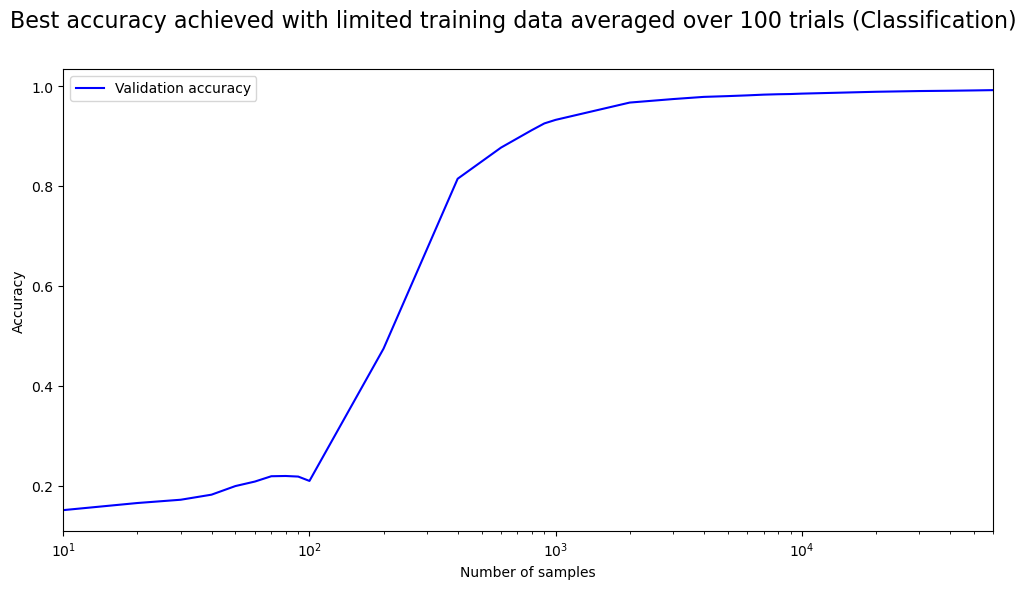

'<table>\n<tbody>\n<tr><td style="text-align: right;">10        </td><td style="text-align: right;">20        </td><td style="text-align: right;">30        </td><td style="text-align: right;">40        </td><td style="text-align: right;">50        </td><td style="text-align: right;">60        </td><td style="text-align: right;">70        </td><td style="text-align: right;">80        </td><td style="text-align: right;">90        </td><td style="text-align: right;">100        </td><td style="text-align: right;">200        </td><td style="text-align: right;">400        </td><td style="text-align: right;">600        </td><td style="text-align: right;">800        </td><td style="text-align: right;">900        </td><td style="text-align: right;">1000         </td><td style="text-align: right;">2000        </td><td style="text-align: right;">3000         </td><td style="text-align: right;">4000         </td><td style="text-align: right;">5000         </td><td style="text-align: right;">6000         </td><td style="text-align: right;">7000         </td><td style="text-align: right;">8000          </td><td style="text-align: right;">9000         </td><td style="text-align: right;">10000          </td><td style="text-align: right;">20000          </td><td style="text-align: right;">30000          </td><td style="text-align: right;">40000          </td><td style="text-align: right;">50000          </td><td style="text-align: right;">60000          </td></tr>\n<tr><td style="text-align: right;"> 0.151158 </td><td style="text-align: right;"> 0.165393 </td><td style="text-align: right;"> 0.171953 </td><td style="text-align: right;"> 0.182093 </td><td style="text-align: right;"> 0.199319 </td><td style="text-align: right;"> 0.208334 </td><td style="text-align: right;"> 0.219005 </td><td style="text-align: right;"> 0.2195   </td><td style="text-align: right;"> 0.218331 </td><td style="text-align: right;">  0.209622 </td><td style="text-align: right;">  0.474554 </td><td style="text-align: right;">  0.814616 </td><td style="text-align: right;">  0.876967 </td><td style="text-align: right;">  0.911888 </td><td style="text-align: right;">  0.925406 </td><td style="text-align: right;">   0.932508  </td><td style="text-align: right;">   0.967141 </td><td style="text-align: right;">   0.97415   </td><td style="text-align: right;">   0.978512  </td><td style="text-align: right;">   0.980059  </td><td style="text-align: right;">   0.981532  </td><td style="text-align: right;">   0.983001  </td><td style="text-align: right;">   0.983794   </td><td style="text-align: right;">   0.984233  </td><td style="text-align: right;">    0.985043   </td><td style="text-align: right;">    0.988742   </td><td style="text-align: right;">    0.990194   </td><td style="text-align: right;">    0.990797   </td><td style="text-align: right;">    0.991445   </td><td style="text-align: right;">    0.992052   </td></tr>\n<tr><td style="text-align: right;"> 0.0317205</td><td style="text-align: right;"> 0.0454006</td><td style="text-align: right;"> 0.0465264</td><td style="text-align: right;"> 0.0446305</td><td style="text-align: right;"> 0.0556768</td><td style="text-align: right;"> 0.0667908</td><td style="text-align: right;"> 0.0655196</td><td style="text-align: right;"> 0.0601463</td><td style="text-align: right;"> 0.0642924</td><td style="text-align: right;">  0.0617301</td><td style="text-align: right;">  0.0932887</td><td style="text-align: right;">  0.0352108</td><td style="text-align: right;">  0.0204796</td><td style="text-align: right;">  0.0140343</td><td style="text-align: right;">  0.0114182</td><td style="text-align: right;">   0.00867355</td><td style="text-align: right;">   0.0022593</td><td style="text-align: right;">   0.00181375</td><td style="text-align: right;">   0.00122281</td><td style="text-align: right;">   0.00123654</td><td style="text-align: right;">   0.00114611</td><td style="text-align: right;">   0.00107596</td><td style="text-align: right;">

In [27]:
data_point_x = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 400, 600, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 20000, 30000, 40000, 50000, 60000]
data_point_values = []
for i in tqdm_notebook(range(100)):
    data_points = []
    for c in data_point_x:
        model = MnistCnn(10).to(device)
        best_acc = classification(model, epochs=10, training_sample_count=c)
        data_points.append(best_acc)
    data_point_values.append(data_points)
aggregated_values = [sum(values) / len(values) for values in zip(*data_point_values)]
plot_progress = Plots(charts={"Validation accuracy": "b"}, title="Best accuracy achieved with limited training data averaged over 100 trials (Classification)", log_x=True, x_axis_title="Number of samples", y_axis_title="Accuracy")
for c, best_acc in zip(data_point_x, aggregated_values):
    plot_progress.add_point("Validation accuracy", c, best_acc)
    plot_progress.plot()
plot_progress.close()

aggregated_values_sq = [sum([v*v for v in values])/len(values) for values in zip(*data_point_values)]
aggregated_values_stdev = [math.sqrt(sq - avg*avg) for sq, avg in zip(aggregated_values_sq, aggregated_values)]
tabulate.tabulate([data_point_x, aggregated_values, aggregated_values_stdev], tablefmt='html')

Used for fine tuning the SSL model and calculating the accuray it acheives

A Siamese model when trained in a supervised paradigm consumes the data in a very specific way. Each mini-batch should be composed of two tensors. Both of these tensors should be the same shape as of your dataset. For example, in the case of MNIST, each sample is an image of 28*28 pixels. Here, as part of the augmentation we will be upscaling them to 32*32. So each input sample is a 1*32*32 tensor. The first 1 is because the images are grayscale.

In our case, if want to have batches of size `b`, each batch will be: `(b*1*32*32, b*1*32*32)`. Meaning each training input will be tuple of two tensors. Each tensor will be of shape `b*1*32*32`. But there's more, the samples in each batch will of the same class as of other batch while no other sample in the batch should of that class. This is depicted in the following image:

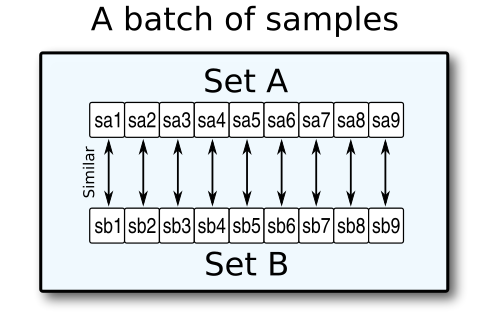

The formal mathematical way of saying the same thing is:

\begin{equation}
  \forall i, j \in B, \begin{cases}
    \text{class(sa[i]) $=$ class(sb[j])}, \:\: & \text{if $i = j$}\\
    \text{class(sa[i]) $\neq$ class(sb[j])}, \:\: & \text{if $i \neq j$} &
  \end{cases}
\end{equation}

The direct result of the above assumption is that the `batch_size` cannot be larger than the number of classes that we have. So here, `batch_size` could be as large as 10. I would like to reiterate that this restriction is only applicable to *supervised learning* version of a Siamese model. This does not apply once we are talking about *self-supervised learning*.

This requirement is satisfied by the classes implemented in this repo seemlessly. All you need to do is to sub-class `SiameseSampleGenerator` to generate samples of a single class per each call. Here's our implementation for MNIST:

Having grouped the samples by their class/label, the `MnistGenerator` class will return one sample of a specific class when called. Then, the `SiameseDataset` class will use these generators to compose batches of data match the structure explained above.

# Supervised Siamese model

## Dataloaders

In [14]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.912], std=[0.168]),
])

training_mnist = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

test_mnist = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

train_samples = [[] for i in range(10)]
for X, y in training_mnist:
    train_samples[y].append(X)

test_samples = [[] for i in range(10)]
for X, y in test_mnist:
    test_samples[y].append(X)

training_generators = [
    torch.utils.data.TensorDataset(torch.stack(train_samples[i]))
    for i in range(class_count)
]

# Test dataloader
test_generators = [
    torch.utils.data.TensorDataset(torch.stack(test_samples[i]))
    for i in range(class_count)
]
test_data = SiameseDataset(test_generators)
test_loader_sl = SiameseDataLoader(test_data, batch_size=batch_size_sl)

## Training and testing function

In [15]:
def accuracy(v1, v2):
    scores = torch.matmul(v1, v2.permute(*range(v2.dim() - 2), -1, -2))
    # scores = torch.mm(v1, v2.t())
    m = torch.argmax(scores, dim=-1).to(v1.device)
    i = torch.arange(scores.shape[-1]).to(v1.device)

    if scores.dim() - i.dim() > 1:
        i = i.expand([*scores.shape[:-2], -1])

    marks = torch.where(i == m, torch.tensor(1).to(v1.device), torch.tensor(0).to(v1.device))
    return torch.sum(marks)

def train_sl(dataloader, model, loss_fn, regularization, optimizer, device):
    model.train()
    total_loss = 0
    total_acc = 0
    num_samples = 0
    model = SiameseModel(model).to(device)
    for batch, (s1, s2) in enumerate(dataloader):
        s1, s2 = s1.to(device), s2.to(device)
        # print(s1.shape)

        batch_size = s1.shape[0]
        class_size = s1.shape[1]
        
        s1 = s1.view(-1, s1.shape[-3], s1.shape[-2], s1.shape[-1])
        s2 = s2.view(-1, s1.shape[-3], s2.shape[-2], s2.shape[-1])
        
        o1, o2 = model((s1, s2))

        o1 = o1.view(batch_size, class_size, -1)
        o2 = o2.view(batch_size, class_size, -1)

        v1 = nn.functional.normalize(o1, dim=-1)
        v2 = nn.functional.normalize(o2, dim=-1)
        
        outputs = torch.stack([o1, o2], dim=0)
        loss = loss_fn(v1, v2) + regularization(outputs)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item() * batch_size * class_size
        total_acc += accuracy(v1, v2).item()
        num_samples += batch_size * class_size

    total_loss /= num_samples
    total_acc /= num_samples

    # print("num_samples: ", num_samples)

    return total_loss, total_acc


def test_sl(dataloader, model, loss_fn, device):
    model.eval()
    test_loss = 0
    test_acc = 0
    num_samples = 0
    model = SiameseModel(model).to(device)
    with torch.no_grad():
        for s1, s2 in dataloader:
            s1, s2 = s1.to(device), s2.to(device)
            
            batch_size = s1.shape[0]
            class_size = s1.shape[1]
            
            s1 = s1.view(-1, s1.shape[-3], s1.shape[-2], s1.shape[-1])
            s2 = s2.view(-1, s1.shape[-3], s2.shape[-2], s2.shape[-1])
            
            o1, o2 = model((s1, s2))
            
            o1 = o1.view(batch_size, class_size, -1)
            o2 = o2.view(batch_size, class_size, -1)

            v1 = torch.nn.functional.normalize(o1, dim=-1)
            v2 = torch.nn.functional.normalize(o2, dim=-1)

            test_loss += loss_fn(v1, v2).item() * batch_size * class_size
            test_acc += accuracy(v1, v2).item()
            num_samples += batch_size * class_size
    test_loss /= num_samples
    test_acc /= num_samples

    return test_loss, test_acc

In [16]:
def jem_sl(model, loss_fn, regularization, plot_title="Training a classification model",
           epochs=20, silent=True, training_sample_count=6000, lr_multiplier=1.0):
    generator = [
        torch.utils.data.TensorDataset(torch.stack(train_samples[i][:training_sample_count]))
        for i in range(class_count)
    ]
    training_data = SiameseDataset(generator)
    train_loader_sl = SiameseDataLoader(training_data, batch_size=batch_size_sl)

    points_sl = [
        {
            "x": "0",
            "y": 0.001 * lr_multiplier
        },
        {
            "control1": {
                "x": 9 / 20 * epochs,
                "y": 0.001 * lr_multiplier
            },
            "control2": {
                "x": 15 / 20 * epochs,
                "y": 0.00001 * lr_multiplier
            }
        },
        {
            "x": epochs,
            "y": 0.00001 * lr_multiplier
        },
        {
            "x": epochs,
            "y": "0"
        }
    ]

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = TheOneLRScheduler(optimizer, points_sl) 

    if silent:
        best_acc = 0
    
        for t in range(epochs):
            train_loss, train_acc = train_sl(train_loader_sl, model, loss_fn, regularization, optimizer, device)
            test_loss, test_acc = test_sl(test_loader_sl, model, loss_fn, device)
            scheduler.step()

            if test_acc > best_acc:
                best_acc = test_acc

            train_loader_sl.dataset.shuffle()
            test_loader_sl.dataset.shuffle()

        return best_acc
    else:
        best_tower = MnistCnn(latent_size)
        best_acc = 0
        plot_data = []
    
        plot_loss = Plots(charts={"Training loss": "g", "Validation loss": "b"}, title=plot_title, log_y=True, y_axis_title="Loss")
        plot_acc = Plots(charts={"Training accuracy": "g", "Validation accuracy": "b"}, y_axis_title="Accuracy")
        for t in tqdm_notebook(range(epochs)):
            train_loss, train_acc = train_sl(train_loader_sl, model, loss_fn, regularization, optimizer, device)
            test_loss, test_acc = test_sl(test_loader_sl, model, loss_fn, device)
            scheduler.step()

            if test_acc > best_acc:
                best_acc = test_acc
                best_tower.load_state_dict(model.state_dict())
            
            plot_loss.add_point("Training loss", t, train_loss)
            plot_loss.add_point("Validation loss", t, test_loss)
            plot_loss.plot()
            
            plot_acc.add_point("Training accuracy", t, train_acc)
            plot_acc.add_point("Validation accuracy", t, test_acc)
            plot_acc.plot()
            
            if t % 5 == 0:
                embeddings, labels = embed_test_data(model)
                plot_data.append({
                    "epoch": t,
                    "validation_accuracy": test_acc,
                    "embeddings": embeddings,
                    "labels": labels,
                })

            train_loader_sl.dataset.shuffle()
            test_loader_sl.dataset.shuffle()
    
        # making sure the final model is evaluated
        if (epochs-1) % 5 != 0:
            embeddings, labels = embed_test_data(model)
            plot_data.append({
                "epoch": t,
                "validation_accuracy": test_acc,
                "embeddings": embeddings,
                "labels": labels,
            })
            
        plot_loss.close()
        plot_acc.close()
    
        return best_tower, best_acc, plot_data

## Training with limited samples

  0%|          | 0/10 [00:00<?, ?it/s]

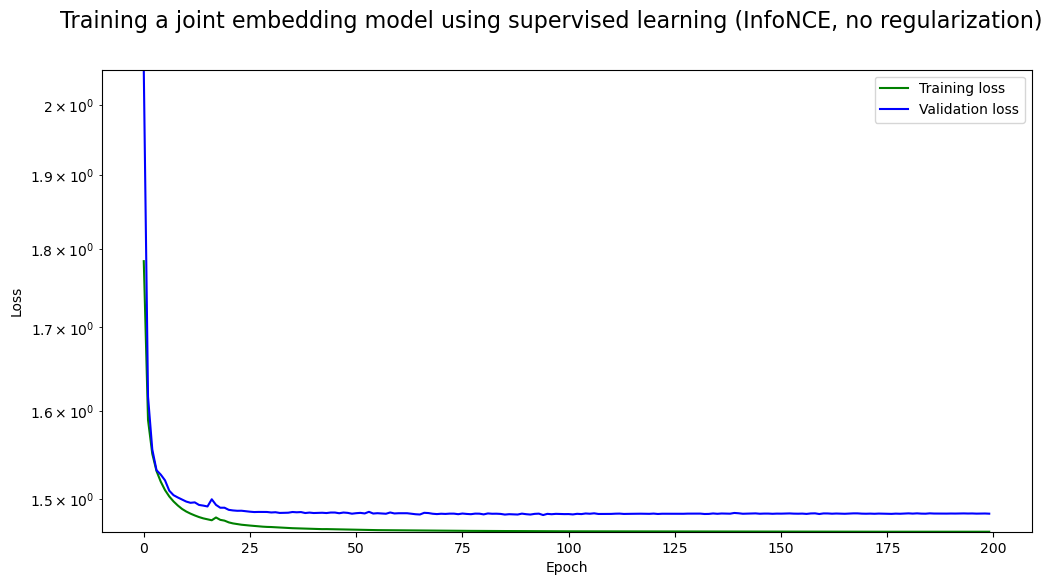

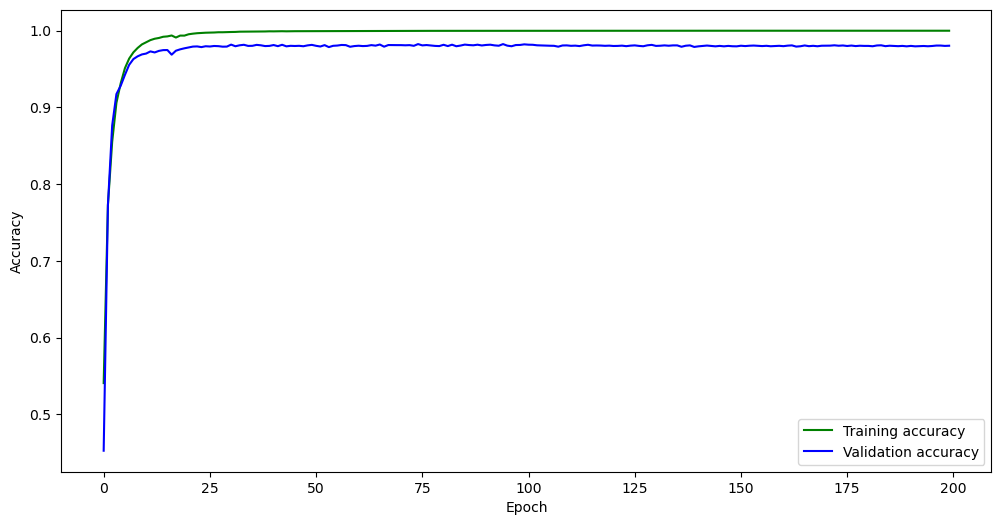

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.982511


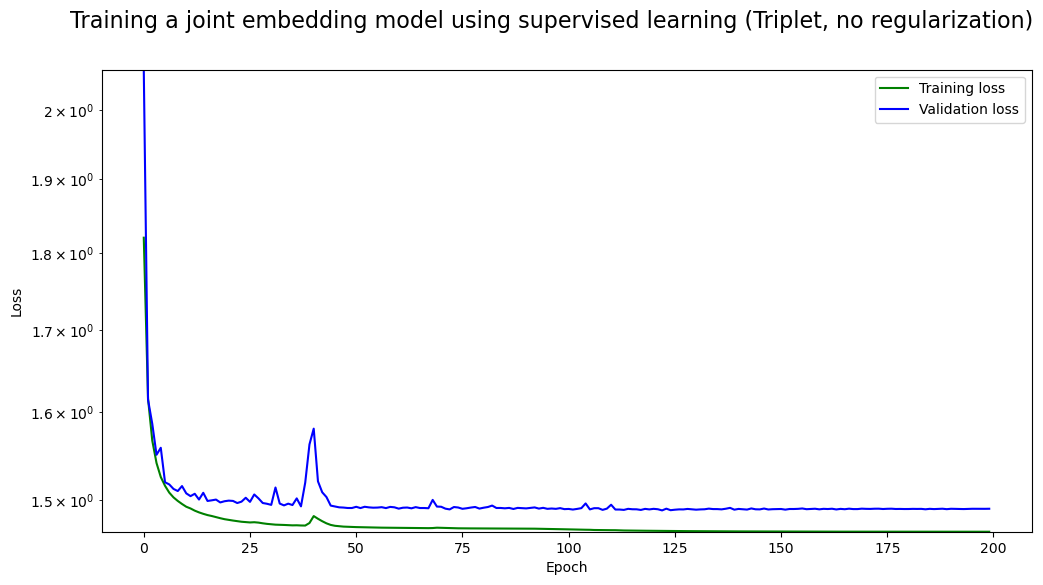

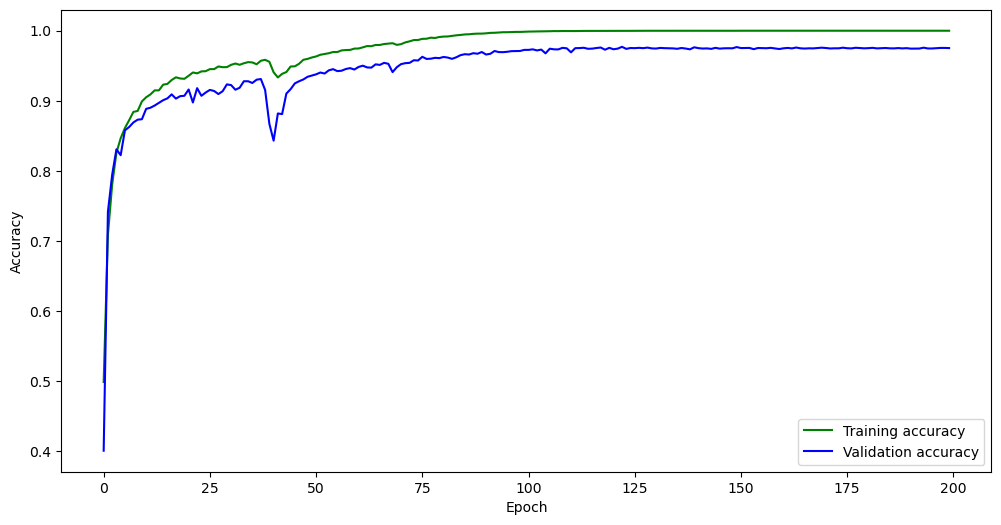

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.976906


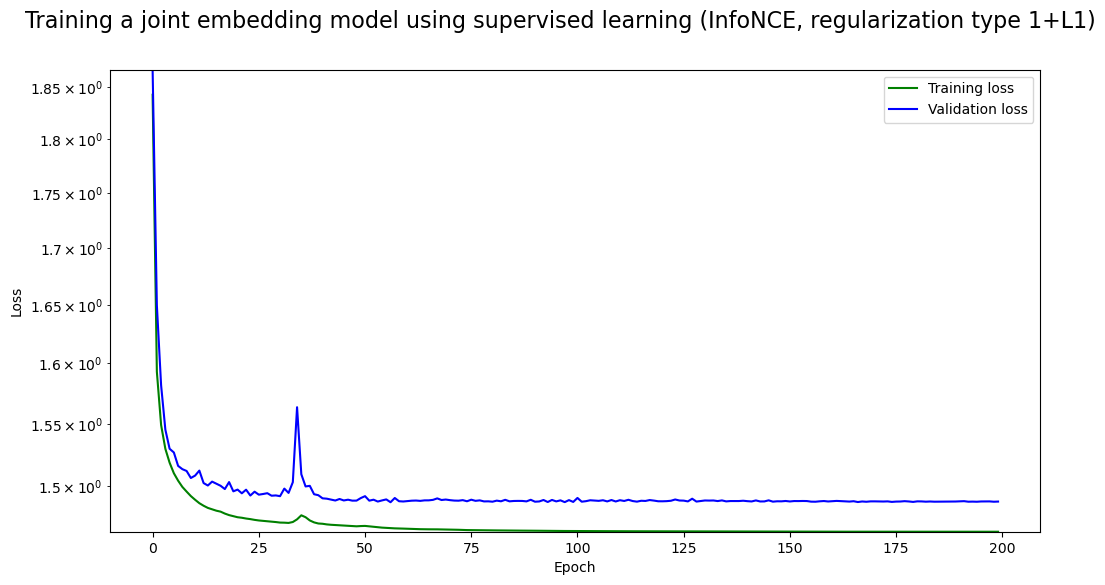

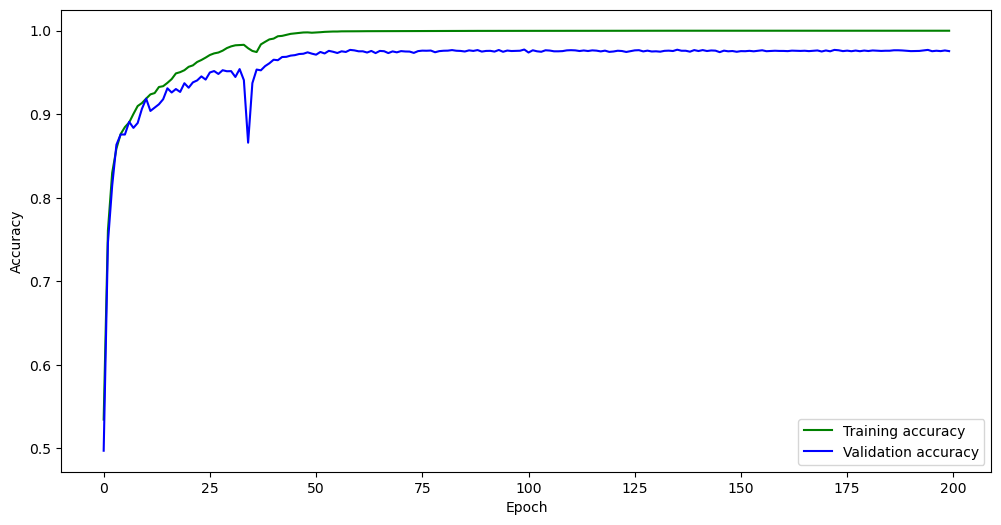

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.977466


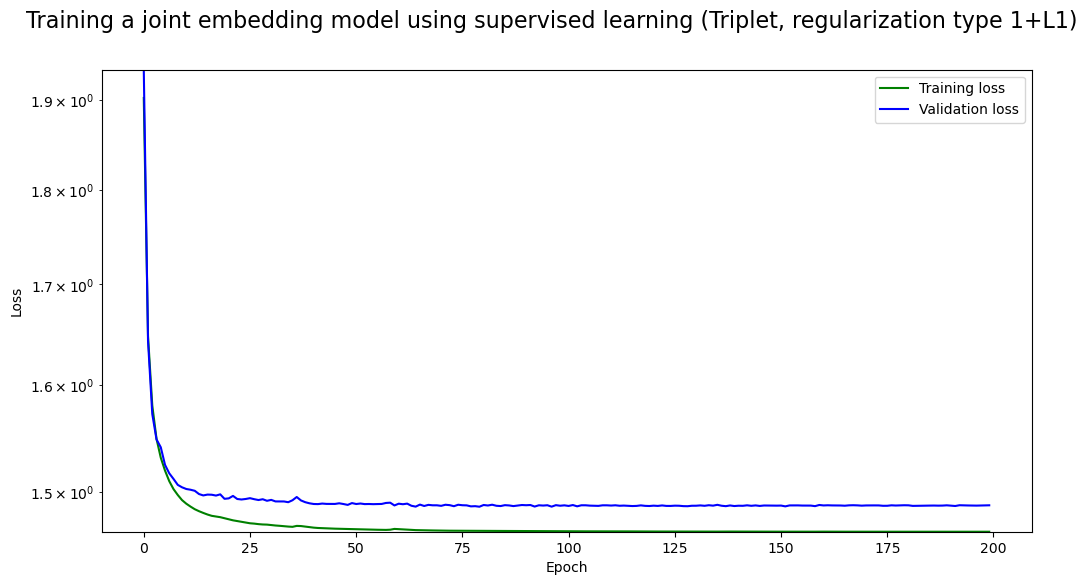

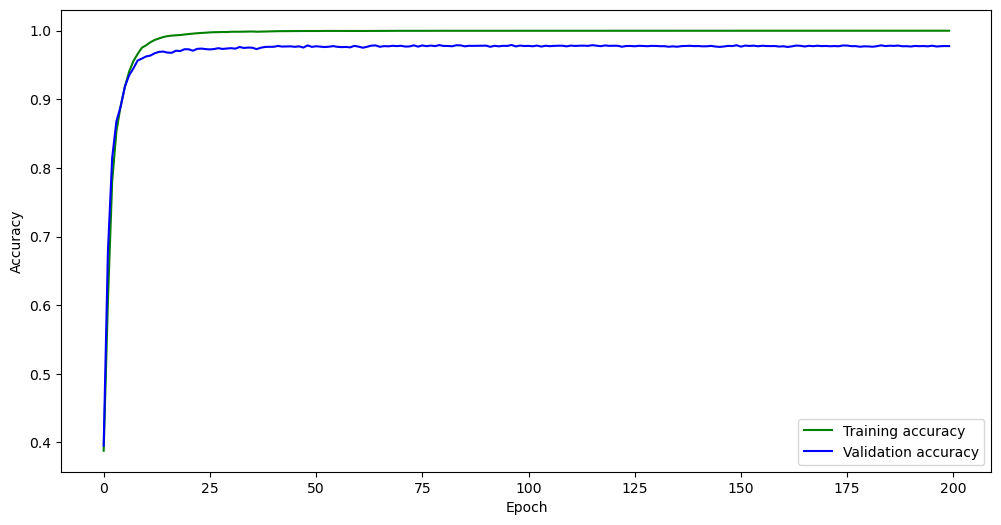

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.979260


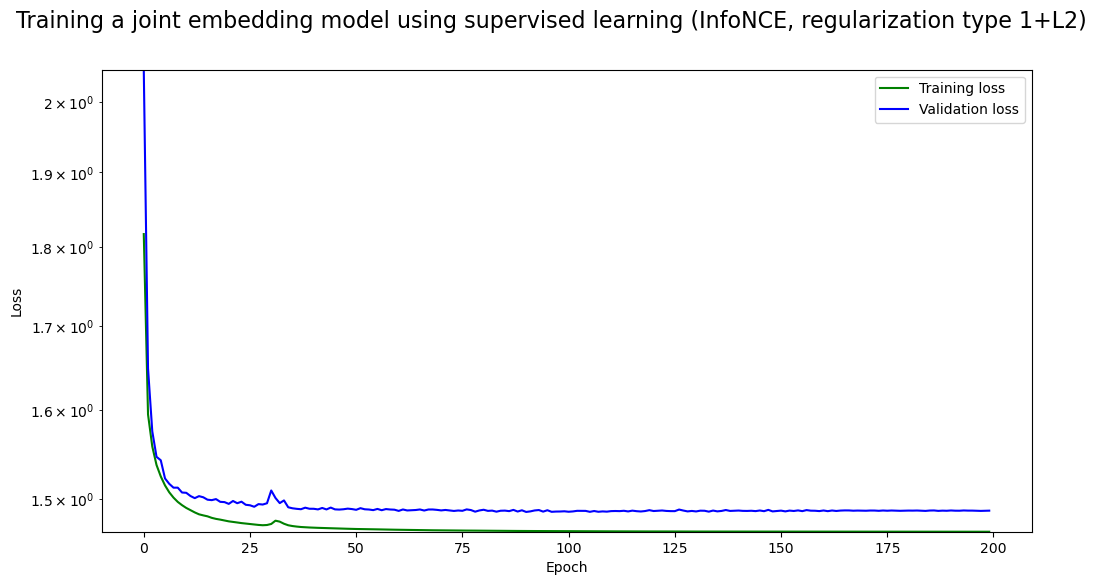

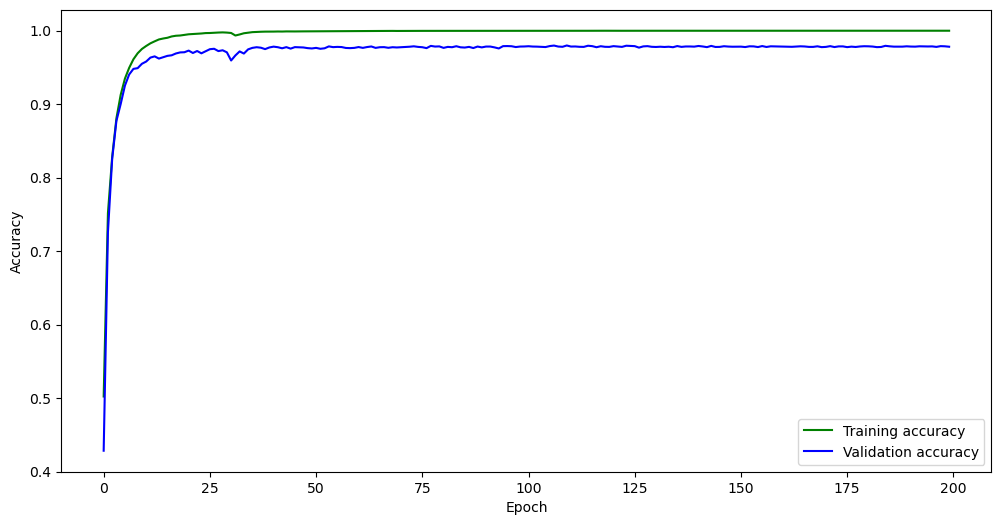

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.979821


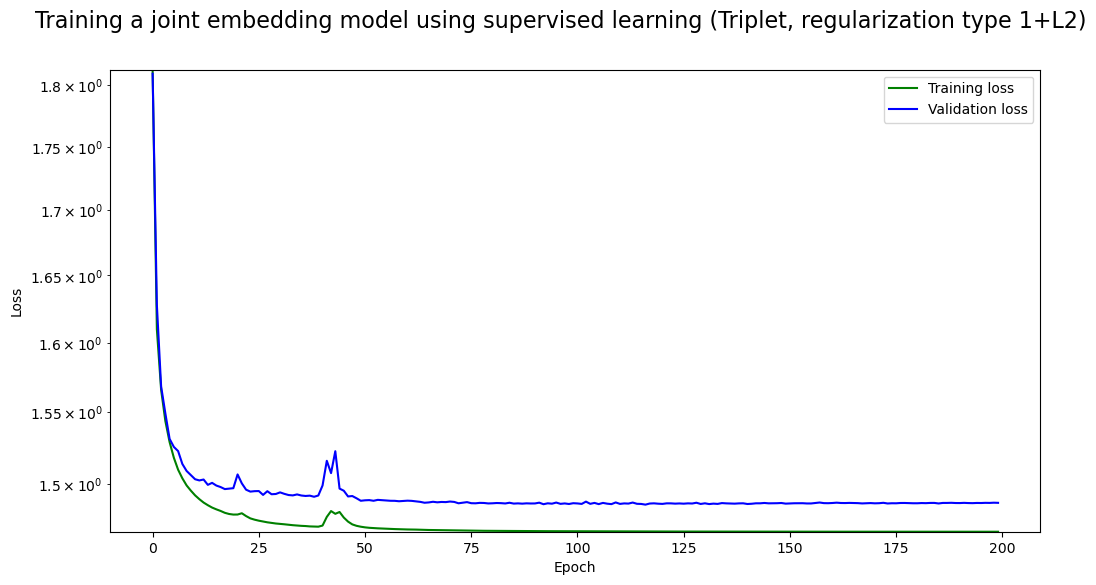

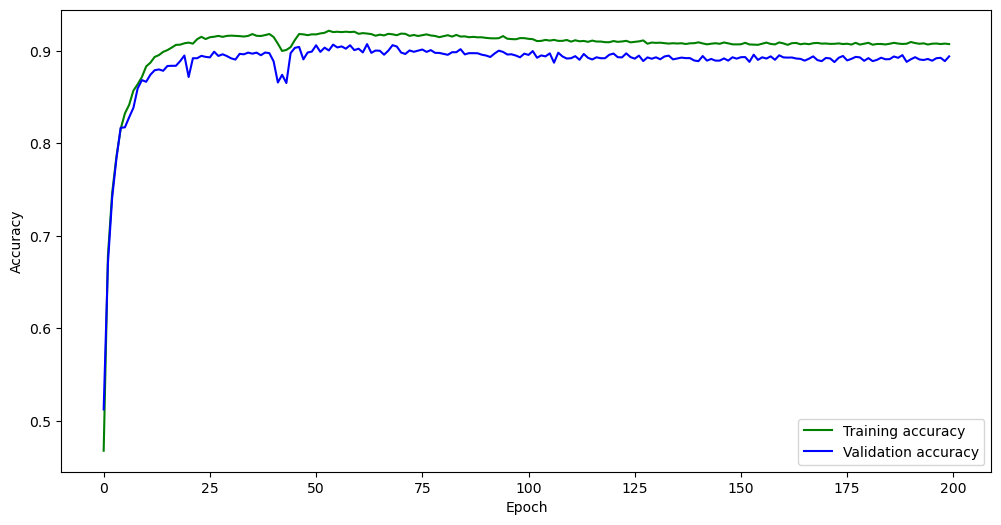

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.907175


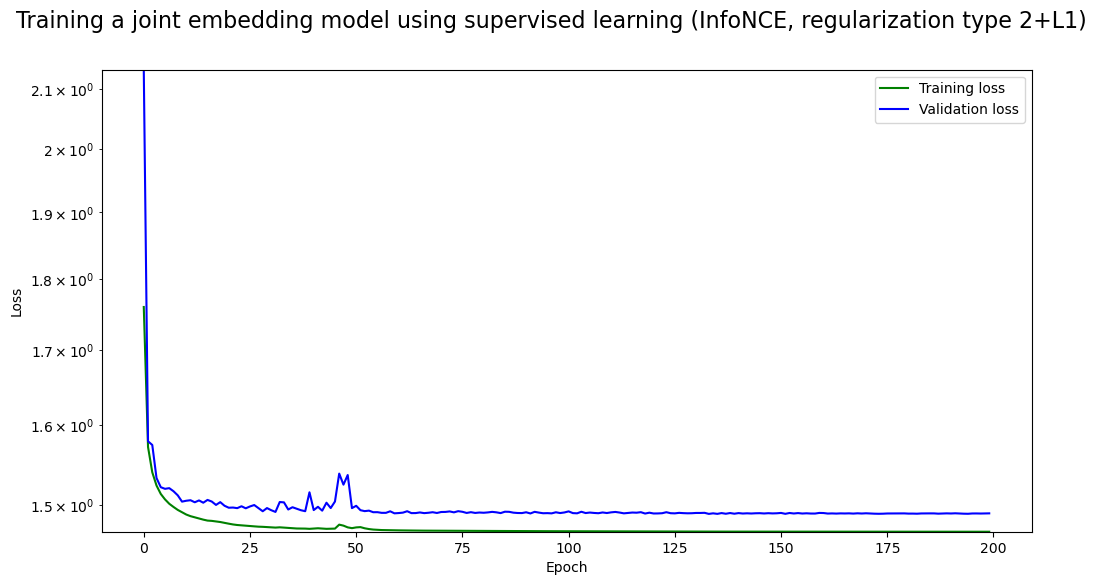

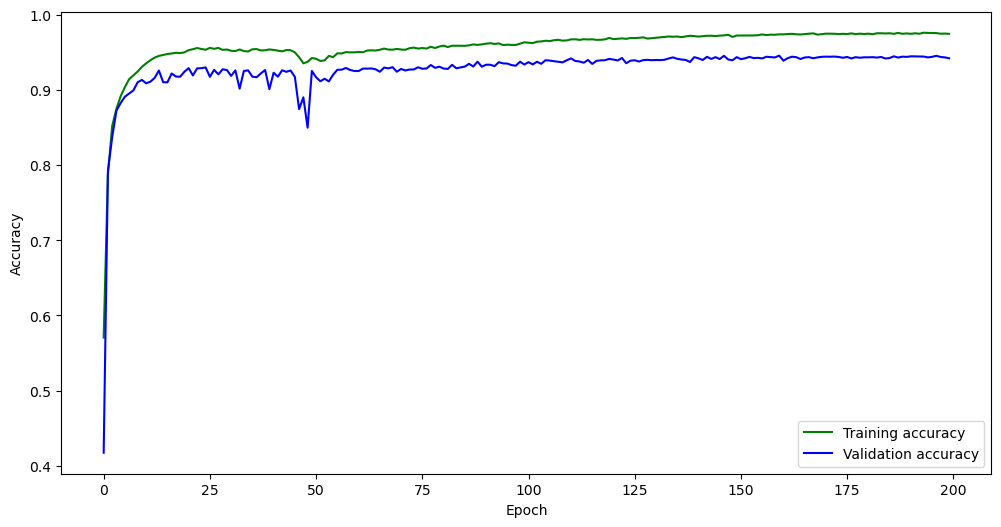

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.945628


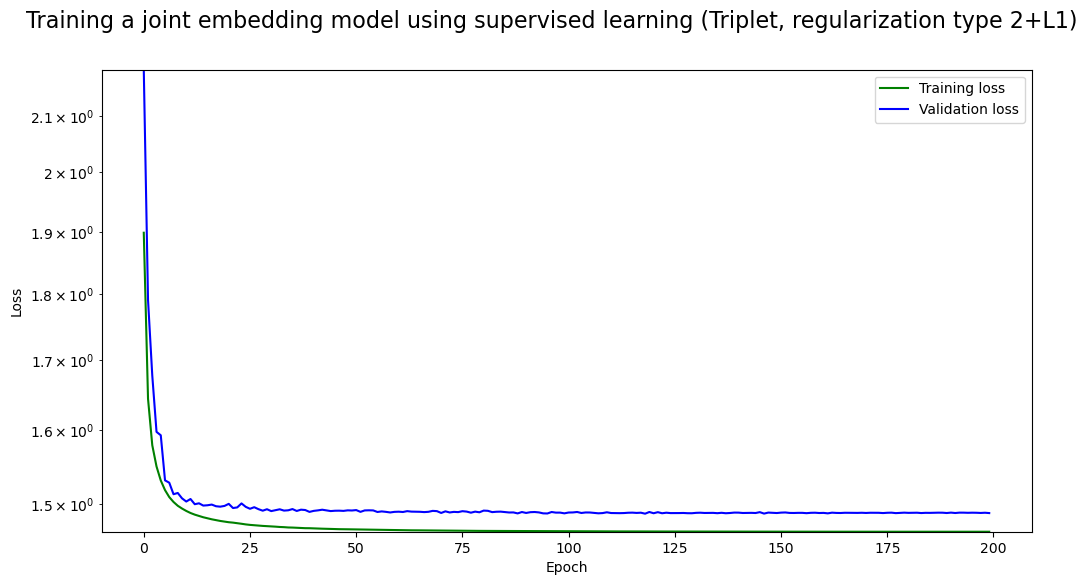

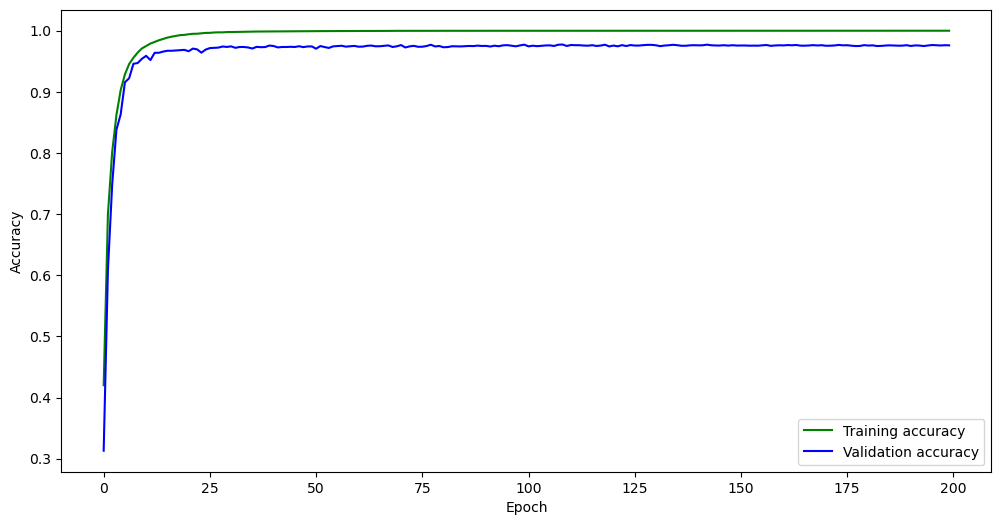

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.977354


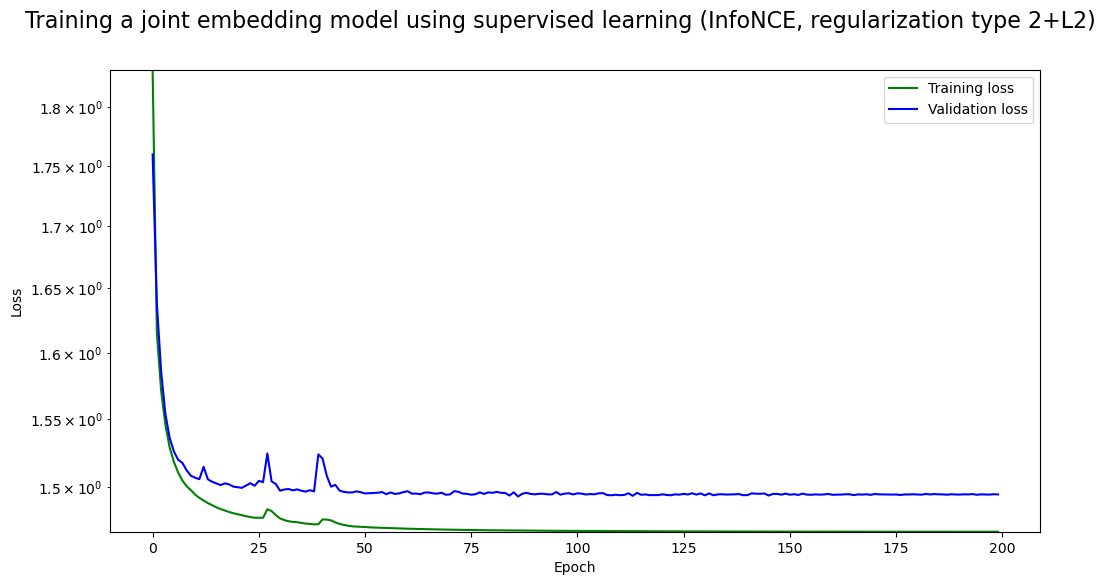

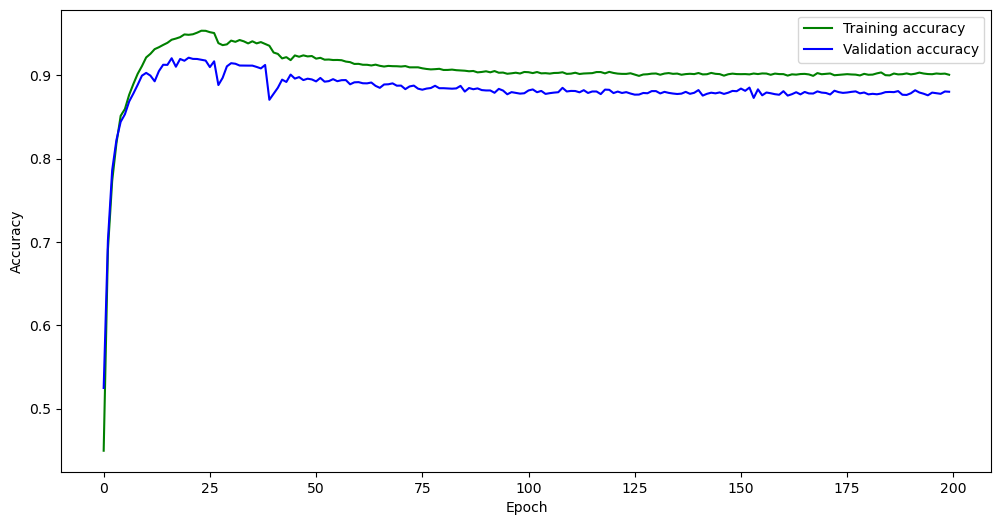

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.921300


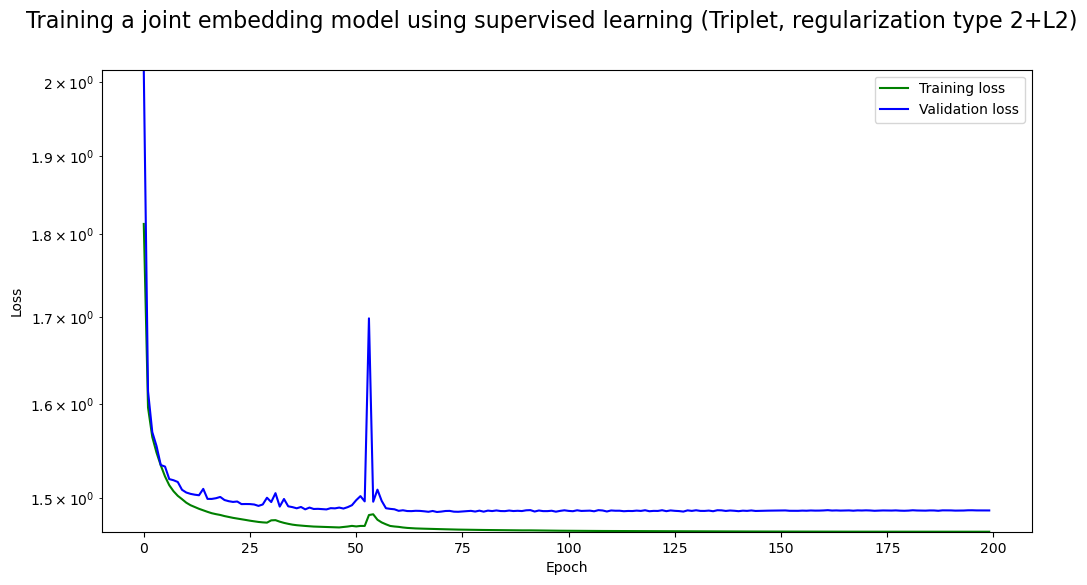

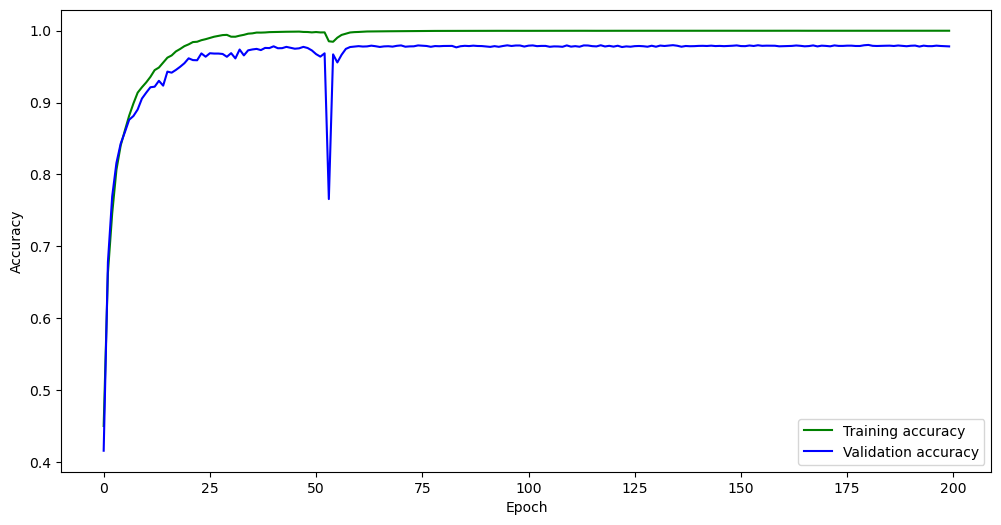

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.980157
{'acc': 0.9825112107623318, 'tower': MnistCnn(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=2048, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (fc): Linear(in_features=32, out_features=3, bias=True)
), 'config': {'regularization': <function no_regularization at 0x7f1790752320>, 'loss_function': <function info_nce_loss 

In [22]:
filename_loss = {
    info_nce_loss: "infonce",
    triplet_loss: "triplet",
}
filename_reg = {
    no_regularization: "noreg",
    norm_regularization_1_l1: "reg1l1",
    norm_regularization_1_l2: "reg1l2",
    norm_regularization_2_l1: "reg2l1",
    norm_regularization_2_l2: "reg2l2",
}

plottitle_loss = {
    info_nce_loss: "InfoNCE",
    triplet_loss: "Triplet",
}

plottitle_reg = {
    no_regularization: "no regularization",
    norm_regularization_1_l1: "regularization type 1+L1",
    norm_regularization_1_l2: "regularization type 1+L2",
    norm_regularization_2_l1: "regularization type 2+L1",
    norm_regularization_2_l2: "regularization type 2+L2",
}

champion_sl = {
    "acc": 0,
    "tower": None,
    "config": None,
}

regularizations = (no_regularization, norm_regularization_1_l1, norm_regularization_1_l2, norm_regularization_2_l1, norm_regularization_2_l2)
loss_functions = (info_nce_loss, triplet_loss)

configs = list(itertools.product(regularizations, loss_functions))

for (reg, loss_fn) in tqdm_notebook(configs):
    plot_title = f"Training a joint embedding model using supervised learning ({plottitle_loss[loss_fn]}, {plottitle_reg[reg]})"
    html_title = f"supervised joint embedding model trained with {plottitle_loss[loss_fn]} loss function and {plottitle_reg[reg]}"
    
    model = MnistCnn(latent_size).to(device)
    best_tower, best_acc, plot_data = jem_sl(model, info_nce_loss, no_regularization,
                                             plot_title=plot_title,
                                             epochs=200, silent=False)
    export_plotly_html(plot_data, f"sl_charts/{filename_loss[loss_fn]}_{filename_reg[reg]}.html", html_title)
    print(f"Best downstream task accuracy: {best_acc:3f}")
    if champion_sl["acc"] < best_acc:
        champion_sl["acc"] = best_acc
        champion_sl["tower"] = best_tower
        champion_sl["config"] = {
            "regularization": reg,
            "loss_function": loss_fn,
        }

torch.save(champion_sl["tower"], "./champion_tower_sl.pt")
print(champion_sl)

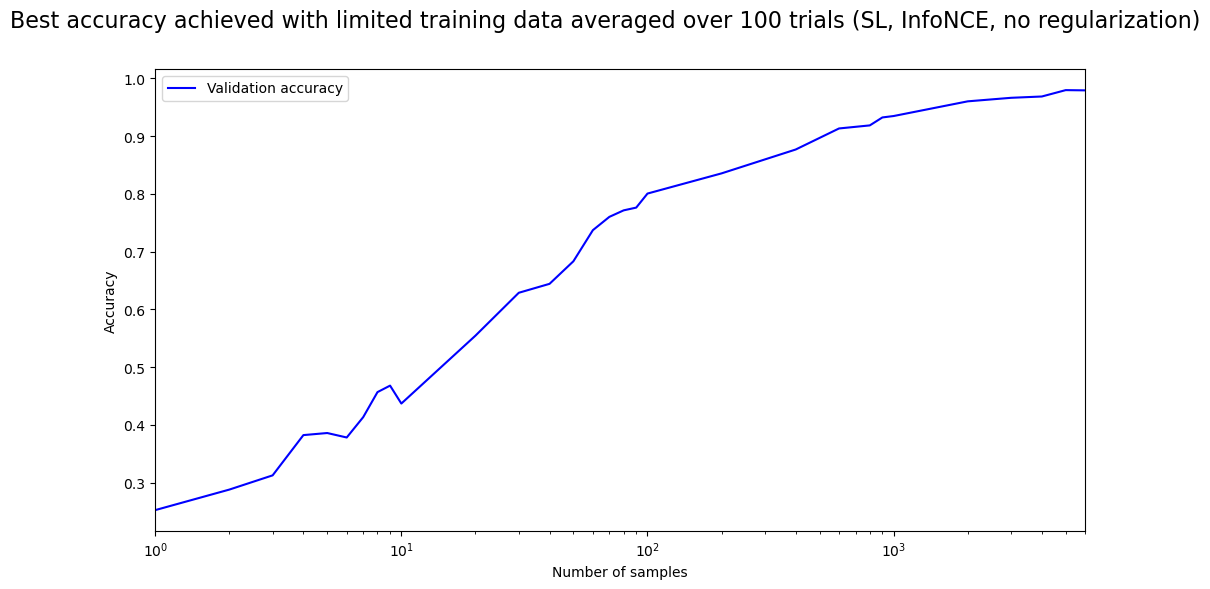

'<table>\n<tbody>\n<tr><td style="text-align: right;">1        </td><td style="text-align: right;">2        </td><td style="text-align: right;">3        </td><td style="text-align: right;">4        </td><td style="text-align: right;">5        </td><td style="text-align: right;">6        </td><td style="text-align: right;">7        </td><td style="text-align: right;">8        </td><td style="text-align: right;">9        </td><td style="text-align: right;">10        </td><td style="text-align: right;">20        </td><td style="text-align: right;">30        </td><td style="text-align: right;">40        </td><td style="text-align: right;">50        </td><td style="text-align: right;">60        </td><td style="text-align: right;">70        </td><td style="text-align: right;">80        </td><td style="text-align: right;">90        </td><td style="text-align: right;">100        </td><td style="text-align: right;">200        </td><td style="text-align: right;">400        </td><td style="text-align: right;">600        </td><td style="text-align: right;">800        </td><td style="text-align: right;">900       </td><td style="text-align: right;">1000        </td><td style="text-align: right;">2000         </td><td style="text-align: right;">3000        </td><td style="text-align: right;">4000        </td><td style="text-align: right;">5000         </td><td style="text-align: right;">6000         </td></tr>\n<tr><td style="text-align: right;">0.252825 </td><td style="text-align: right;">0.288341 </td><td style="text-align: right;">0.312982 </td><td style="text-align: right;">0.382646 </td><td style="text-align: right;">0.386244 </td><td style="text-align: right;">0.378498 </td><td style="text-align: right;">0.413733 </td><td style="text-align: right;">0.457029 </td><td style="text-align: right;">0.468274 </td><td style="text-align: right;"> 0.437253 </td><td style="text-align: right;"> 0.55472  </td><td style="text-align: right;"> 0.628935 </td><td style="text-align: right;"> 0.644406 </td><td style="text-align: right;"> 0.683453 </td><td style="text-align: right;"> 0.737287 </td><td style="text-align: right;"> 0.760303 </td><td style="text-align: right;"> 0.771547 </td><td style="text-align: right;"> 0.776334 </td><td style="text-align: right;">  0.800617 </td><td style="text-align: right;">  0.835572 </td><td style="text-align: right;">  0.87685  </td><td style="text-align: right;">  0.913285 </td><td style="text-align: right;">  0.918565 </td><td style="text-align: right;">  0.932343</td><td style="text-align: right;">   0.934798 </td><td style="text-align: right;">   0.960213  </td><td style="text-align: right;">   0.966323 </td><td style="text-align: right;">   0.968587 </td><td style="text-align: right;">   0.979619  </td><td style="text-align: right;">   0.979204  </td></tr>\n<tr><td style="text-align: right;">0.0273208</td><td style="text-align: right;">0.0272751</td><td style="text-align: right;">0.0224871</td><td style="text-align: right;">0.0483599</td><td style="text-align: right;">0.0415513</td><td style="text-align: right;">0.0369566</td><td style="text-align: right;">0.0303459</td><td style="text-align: right;">0.0352119</td><td style="text-align: right;">0.0217973</td><td style="text-align: right;"> 0.0301348</td><td style="text-align: right;"> 0.0211849</td><td style="text-align: right;"> 0.0287811</td><td style="text-align: right;"> 0.0355704</td><td style="text-align: right;"> 0.0236269</td><td style="text-align: right;"> 0.0266142</td><td style="text-align: right;"> 0.0335258</td><td style="text-align: right;"> 0.0203811</td><td style="text-align: right;"> 0.0191912</td><td style="text-align: right;">  0.0228488</td><td style="text-align: right;">  0.0202795</td><td style="text-align: right;">  0.0242511</td><td style="text-align: right;">  0.0239069</td><td style="text-align: right;">  0.0241515</td><td style="text-align: right;">  0.019392</td><td style="text-align: right;">   0.0153163</td><td style="text-align: ri

In [26]:
data_point_x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 400, 600, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000]
data_point_values = []
for i in tqdm_notebook(range(10)):
    data_points = []
    for c in data_point_x:
        model = MnistCnn(latent_size).to(device)
        best_acc = jem_sl(model, champion_sl["config"]["loss_function"], champion_sl["config"]["regularization"], epochs=200, silent=True, training_sample_count=c)
        data_points.append(best_acc)
    data_point_values.append(data_points)
aggregated_values = [sum(values) / len(values) for values in zip(*data_point_values)]
plot_progress = Plots(charts={"Validation accuracy": "b"},
                      title=f"Best accuracy achieved with limited training data averaged over 100 trials (SL, {plottitle_loss[champion_sl['config']['loss_function']]}, {plottitle_reg[champion_sl['config']['regularization']]})",
                      log_x=True, x_axis_title="Number of samples", y_axis_title="Accuracy")
for c, best_acc in zip(data_point_x, aggregated_values):
    plot_progress.add_point("Validation accuracy", c, best_acc)
    plot_progress.plot()
plot_progress.close()
aggregated_values_sq = [sum([v*v for v in values])/len(values) for values in zip(*data_point_values)]
aggregated_values_stdev = [math.sqrt(sq - avg*avg) for sq, avg in zip(aggregated_values_sq, aggregated_values)]
tabulate.tabulate([data_point_x, aggregated_values, aggregated_values_stdev], tablefmt='html')

# Self-supervised learning

## Dataloaders

In [17]:
class MnistSslDatasetWithTransform(torch.utils.data.Dataset):
    def __init__(self, data, device, augment=False, augment_both_sides=False):
        super(MnistSslDatasetWithTransform, self).__init__()
        self.device = device
        self.augment_both_sides = augment_both_sides
        self.augment = augment
        images = []
        load_image = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((32, 32), antialias=True),
        ])
        self.dataset = [load_image(img).to(device) for img, _ in data]
        self.target = torch.zeros(1, device='cpu')
        self.transform1 = transforms.Compose([
            transforms.Normalize(mean=[0.912], std=[0.168]),
        ])
        self.transform2 = transforms.Compose([
            transforms.RandomAffine((-10, 10), (0.1, 0.1), (0.8, 1.2), interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
            transforms.Normalize(mean=[0.912], std=[0.168]),
        ])

    def __getitem__(self, index):
        img = self.dataset[index]

        if self.augment:
            if not self.augment_both_sides:
                img1 = self.transform1(img)
            else:
                img1 = self.transform2(img)
            img2 = self.transform2(img)
        else:
            img1 = self.transform1(img)
            img2 = self.transform1(img)
        inputs = torch.stack([img1, img2])

        return inputs, self.target

    def __len__(self):
        return len(self.dataset)


class SimpleCustomBatch:
    def __init__(self, inputs, targets):
        self.inputs, self.targets = inputs, targets # zip(*samples)
        
    # custom memory pinning method on custom type
    def pin_memory(self):
        self.inputs = self.inputs.pin_memory()
        # self.targets = self.targets.pin_memory()
        return self

def collator(samples):
    inputs, targets = zip(*samples)
    inputs = torch.stack(list(inputs))
    return SimpleCustomBatch(inputs.view(-1, inputs.shape[-3], inputs.shape[-2], inputs.shape[-1]), targets)

In [18]:
train_mnist_ssl = datasets.MNIST(
    root="data",
    train=True,
    download=True,
)
train_loader_ssl = torch.utils.data.DataLoader(
    MnistSslDatasetWithTransform(train_mnist_ssl, device='cpu', augment=True, augment_both_sides=False),
    collate_fn=collator,
    shuffle=True,
    batch_size=batch_size_ssl,
    num_workers=16,
    prefetch_factor=2,
    pin_memory=True,
    pin_memory_device=device,
)

test_mnist_ssl = datasets.MNIST(
    root="data",
    train=False,
    download=True,
)
test_loader_ssl = torch.utils.data.DataLoader(
    MnistSslDatasetWithTransform(test_mnist_ssl, device='cpu', augment=True, augment_both_sides=False),
    collate_fn=collator,
    shuffle=False,
    batch_size=batch_size_ssl,
    num_workers=16,
    prefetch_factor=2,
    pin_memory=True,
    pin_memory_device=device,
)

## Training and testing functions

In [19]:
def train_ssl(dataloader, model, loss_fn, regularization, optimizer, device):
    model.train()
    total_loss = 0
    total_acc = 0
    num_samples = 0

    for batch, pinned in enumerate(dataloader):
        if isinstance(pinned, tuple):
            (inputs, targets) = pinned
        else:
            (inputs, targets) = pinned.inputs, pinned.targets
        inputs = inputs.to(device)

        # Compute prediction error
        outputs = model(inputs)

        vectors = nn.functional.normalize(outputs, dim=-1)
        vectors = vectors.view(vectors.shape[0]//2, 2, vectors.shape[-1])
        v1 = vectors[:, 0, :]
        v2 = vectors[:, 1, :]
        loss = loss_fn(v1, v2) + regularization(outputs)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item() * v1.shape[0]
        total_acc += accuracy(v1, v2).item()
        num_samples += v1.shape[0]

    total_loss /= num_samples
    total_acc /= num_samples

    return total_loss, total_acc


def test_ssl(dataloader, model, loss_fn, device):
    model.eval()
    test_loss = 0
    test_acc = 0
    num_samples = 0
    with torch.no_grad():
        for pinned in dataloader:
            if isinstance(pinned, tuple):
                (inputs, targets) = pinned
            else:
                (inputs, targets) = pinned.inputs, pinned.targets
            inputs = inputs.to(device)
            outputs = model(inputs)

            vectors = nn.functional.normalize(outputs, dim=-1)
            vectors = vectors.view(vectors.shape[0]//2, 2, vectors.shape[-1])
            v1 = vectors[:, 0, :]
            v2 = vectors[:, 1, :]
            test_loss += loss_fn(v1, v2).item() * v1.shape[0]
            test_acc += accuracy(v1, v2).item()
            num_samples += v1.shape[0]
        test_loss /= num_samples
        test_acc /= num_samples

    return test_loss, test_acc

def fine_tune_downstream_task(model, epochs=10, training_sample_count=60000, DownstreamClass=ClusteredMnistCnn):
    labeled_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(mnist_data[:training_sample_count], mnist_targets[:training_sample_count]),
        shuffle=True,
        batch_size=training_sample_count,
        num_workers=16,
        prefetch_factor=2,
    )
    downstream_model = DownstreamClass(model, labeled_loader, 10, device).to(device)
    return classification(downstream_model, epochs=epochs, training_sample_count=training_sample_count, lr_multiplier=1)

In [20]:
def jem_ssl(model, loss_fn, regularization, plot_title="Training a self-supervised model", finetune_with_sl=True,
           epochs=20, downstream_epochs=20, downstream_sample_count=40, silent=True, lr_multiplier=1):
    generator = [
        torch.utils.data.TensorDataset(torch.stack(train_samples[i][:downstream_sample_count]))
        for i in range(class_count)
    ]
    training_data = SiameseDataset(generator)
    train_loader_sl = SiameseDataLoader(training_data, batch_size=batch_size_sl)

    points_ssl = [
        {
            "x": "0",
            "y": 0.001 * lr_multiplier
        },
        {
            "control1": {
                "x": 9 / 20 * epochs,
                "y": 0.001 * lr_multiplier
            },
            "control2": {
                "x": 15 / 20 * epochs,
                "y": 0.00001 * lr_multiplier
            }
        },
        {
            "x": epochs,
            "y": 0.00001 * lr_multiplier
        },
        {
            "x": epochs,
            "y": "0"
        }
    ]

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = TheOneLRScheduler(optimizer, points_ssl) 

    if silent:
        best_acc = 0
    
        for t in range(epochs):
            train_loss_ssl, train_acc_ssl = train_ssl(train_loader_ssl, model, loss_fn, regularization, optimizer, device)
            if finetune_with_sl:
                train_loss_sl, train_acc_sl = train_sl(train_loader_sl, model, loss_fn, regularization, optimizer, device)
            down_stream_acc = fine_tune_downstream_task(model, epochs=downstream_epochs, training_sample_count=downstream_sample_count)
            scheduler.step()

            if down_stream_acc > best_acc:
                best_acc = down_stream_acc

        return best_acc
    else:
        best_tower = MnistCnn(latent_size)
        best_acc = 0
        plot_data = []

        if finetune_with_sl:
            plot_loss = Plots(charts={"SSL Training loss": "#17becf", "SSL Validation loss": "#1f77b4",
                                      "SL Training loss": "#ff7f0e", "SL Validation loss": "#d62728"},
                              title=plot_title, log_y=True, y_axis_title="Loss")
            plot_acc = Plots(charts={"SSL Training accuracy": "#17becf", "SSL Validation accuracy": "#1f77b4",
                                     f"SL Training accuracy with {downstream_sample_count} training samples": "#ff7f0e",
                                     f"SL Validation accuracy with {downstream_sample_count} training samples": "#d62728",
                                     f"Downstream accuracy with {downstream_sample_count} training samples": "black"},
                             y_axis_title="Accuracy")
        else:
            plot_loss = Plots(charts={"SSL Training loss": "#17becf",
                                      "SSL Validation loss": "#1f77b4"},
                              title=plot_title, log_y=True, y_axis_title="Loss")
            plot_acc = Plots(charts={"SSL Training accuracy": "#17becf", "SSL Validation accuracy": "#1f77b4",
                                     f"Downstream accuracy with {downstream_sample_count} training samples": "black"},
                             y_axis_title="Accuracy")

        for t in tqdm_notebook(range(epochs)):
            train_loss_ssl, train_acc_ssl = train_ssl(train_loader_ssl, model, loss_fn, regularization, optimizer, device)
            test_loss_ssl, test_acc_ssl = test_ssl(test_loader_ssl, model, loss_fn, device)
            if finetune_with_sl:
                train_loss_sl, train_acc_sl = train_sl(train_loader_sl, model, loss_fn, regularization, optimizer, device)
            test_loss_sl, test_acc_sl = test_sl(test_loader_sl, model, loss_fn, device)
            down_stream_acc = fine_tune_downstream_task(model, epochs=downstream_epochs, training_sample_count=downstream_sample_count)
            scheduler.step()

            if down_stream_acc > best_acc:
                best_acc = down_stream_acc
                best_tower.load_state_dict(model.state_dict())
            
            plot_loss.add_point("SSL Training loss", t, train_loss_ssl)
            plot_loss.add_point("SSL Validation loss", t, test_loss_ssl)
            if finetune_with_sl:
                plot_loss.add_point("SL Training loss", t, train_loss_sl)
                plot_loss.add_point("SL Validation loss", t, test_loss_sl)
            plot_loss.plot()
            
            plot_acc.add_point("SSL Training accuracy", t, train_acc_ssl)
            plot_acc.add_point("SSL Validation accuracy", t, test_acc_ssl)
            if finetune_with_sl:
                plot_acc.add_point(f"SL Training accuracy with {downstream_sample_count} training samples", t, train_acc_sl)
                plot_acc.add_point(f"SL Validation accuracy with {downstream_sample_count} training samples", t, test_acc_sl)
            plot_acc.add_point(f"Downstream accuracy with {downstream_sample_count} training samples", t, down_stream_acc)
            plot_acc.plot()
            
            if t % 5 == 0:
                embeddings, labels = embed_test_data(model)
                plot_data.append({
                    "epoch": t,
                    "validation_accuracy": down_stream_acc,
                    "embeddings": embeddings,
                    "labels": labels,
                })
    
        # making sure the final model is evaluated
        if (epochs-1) % 5 != 0:
            embeddings, labels = embed_test_data(model)
            plot_data.append({
                "epoch": t,
                "validation_accuracy": down_stream_acc,
                "embeddings": embeddings,
                "labels": labels,
            })
            
        plot_loss.close()
        plot_acc.close()
    
        return best_tower, best_acc, plot_data

## Training the model

The training step of a Siamese model is exactly the same as any ordinary model. The only difference is that the dataloader as well as the model deal with the data in pairs.

Now we can use our trained model and generate the embeddings for each of the samples. Once we have the embeddings, a simple matrix multiplication will give us the cosine distance between any two samples.

  0%|          | 0/20 [00:00<?, ?it/s]

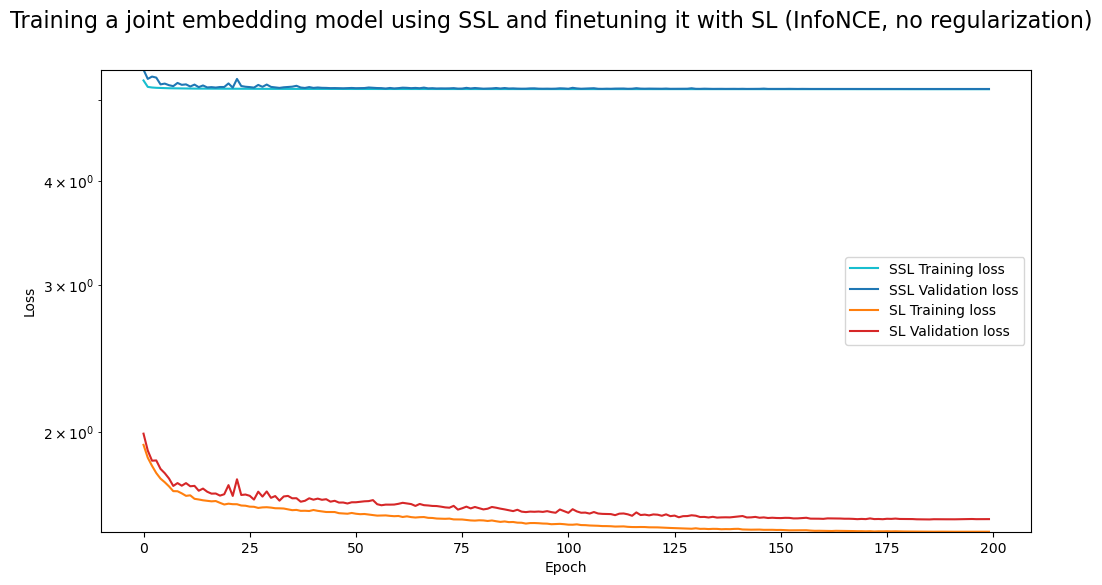

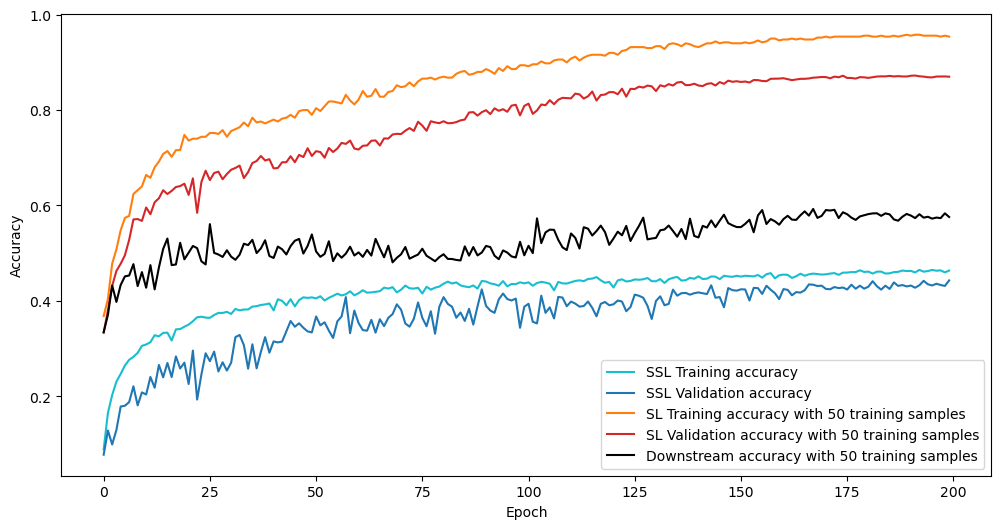

  0%|          | 0/200 [00:00<?, ?it/s]

/home/mehran/.conda/envs/pytorch/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Best downstream task accuracy: 0.592700


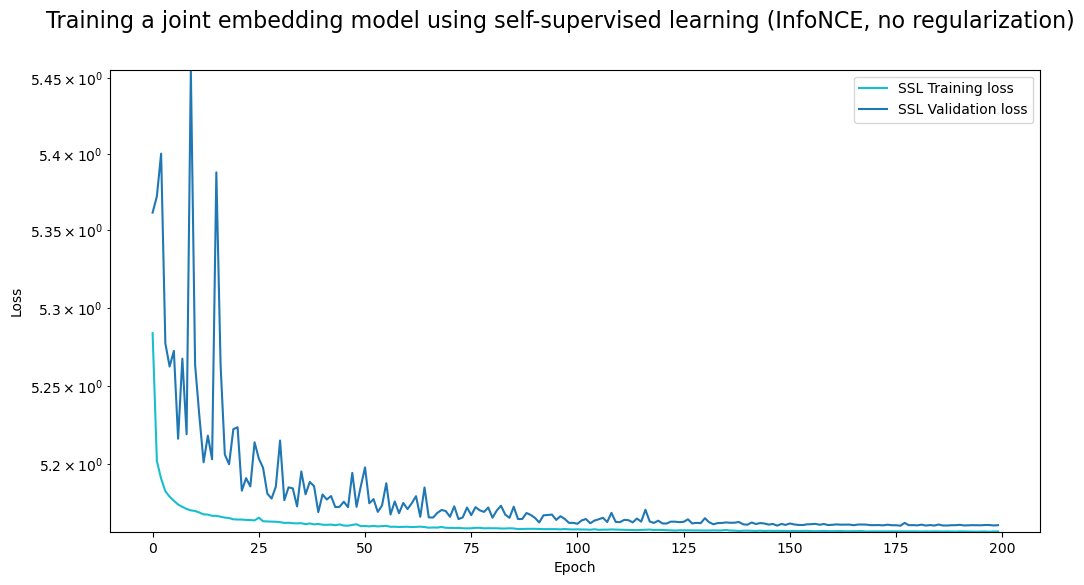

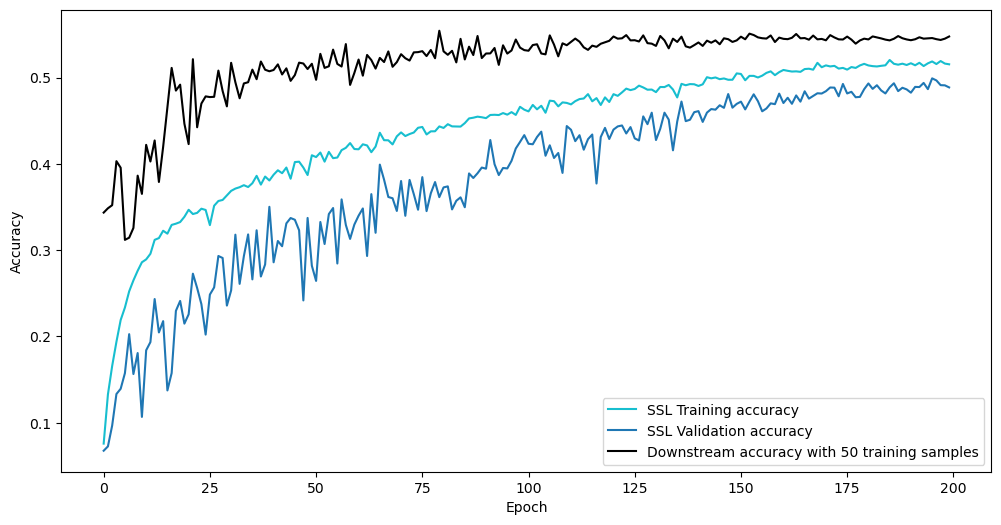

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.554400


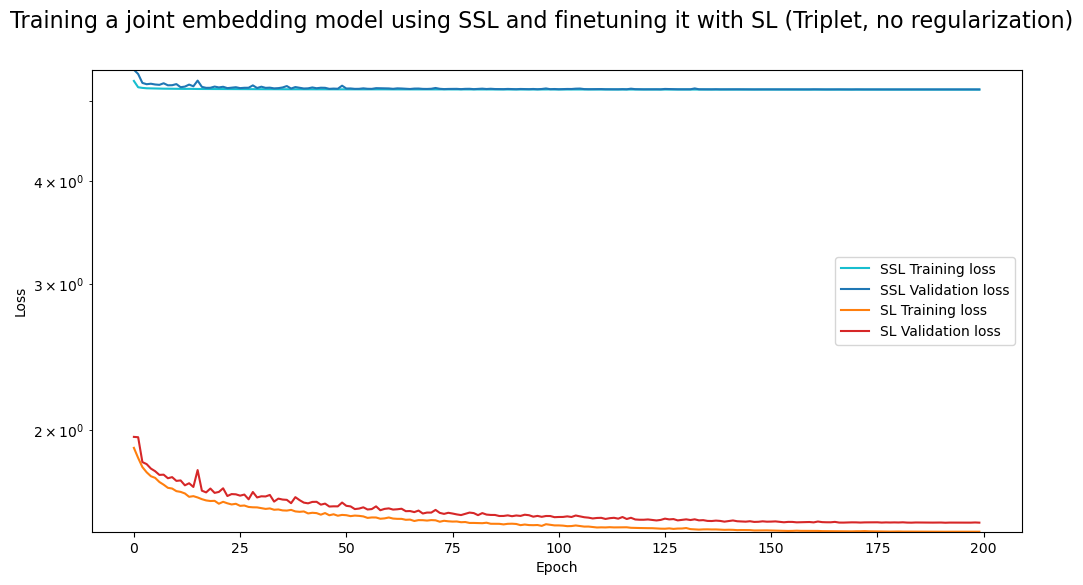

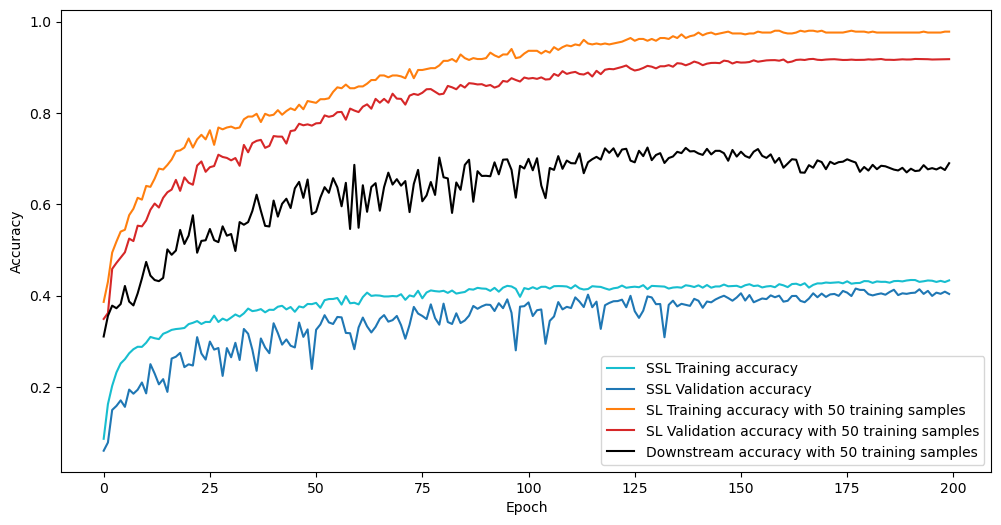

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.724100


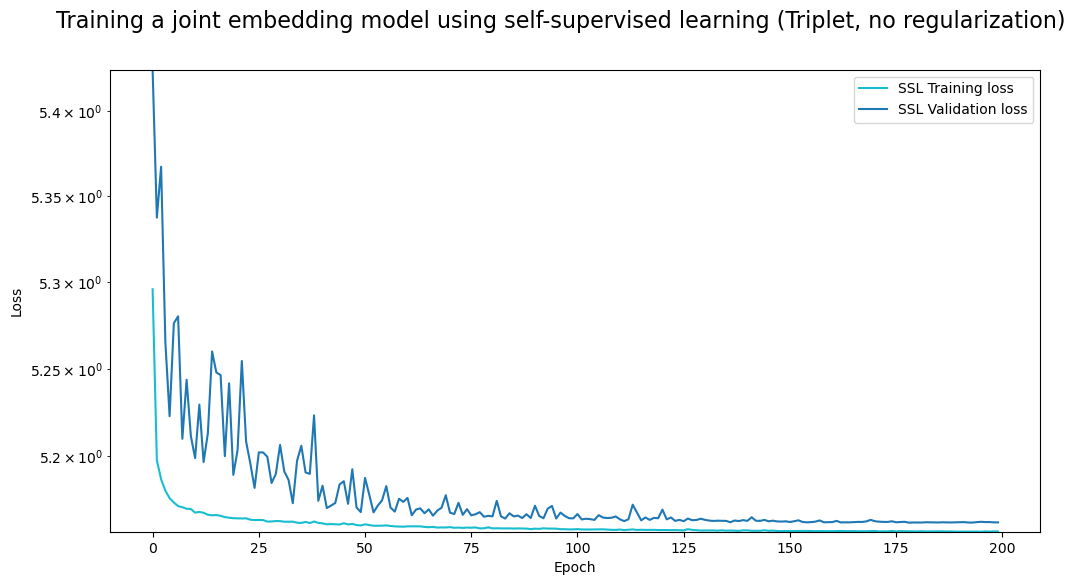

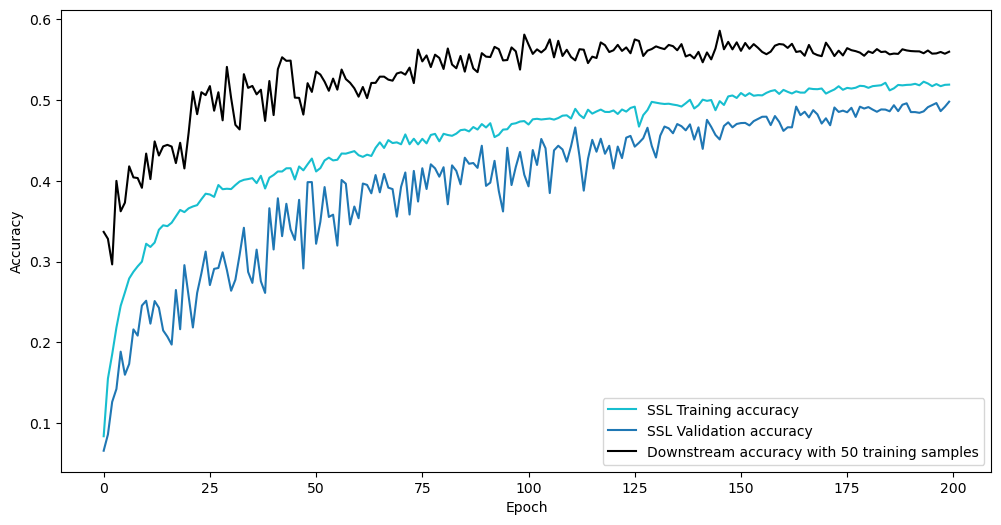

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.586000


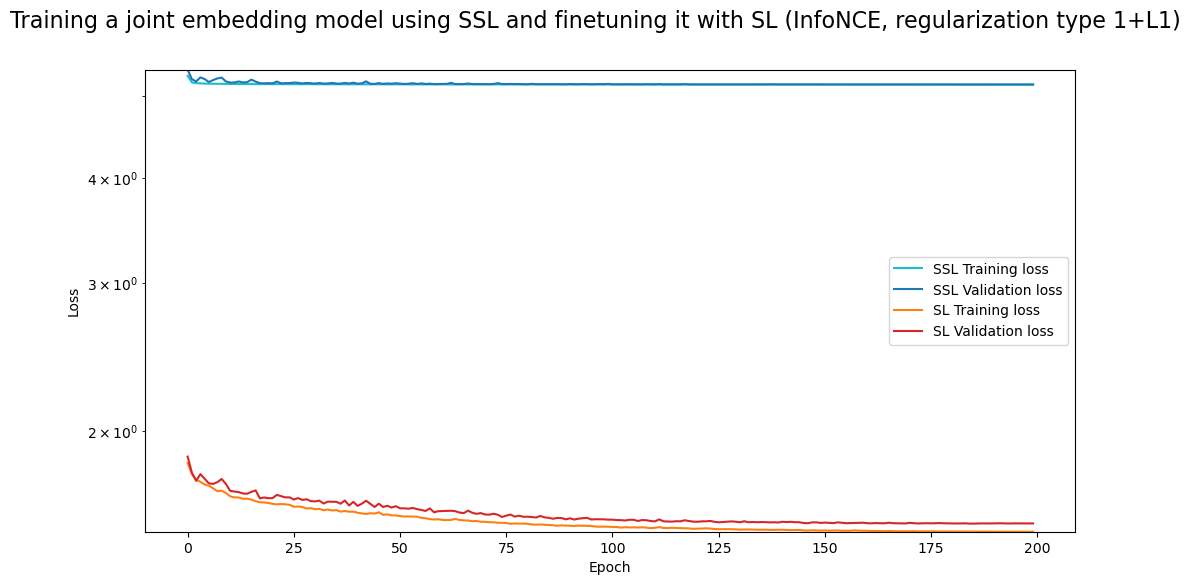

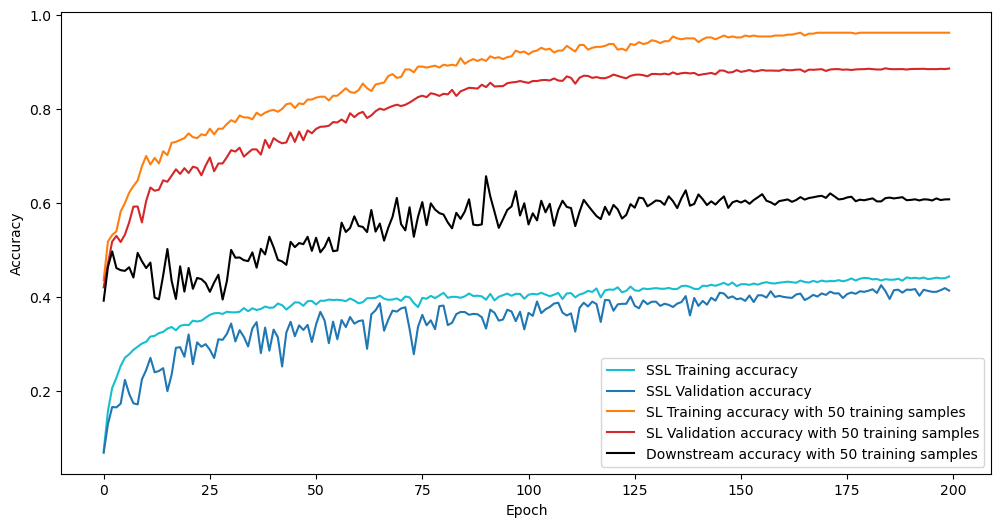

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.657000


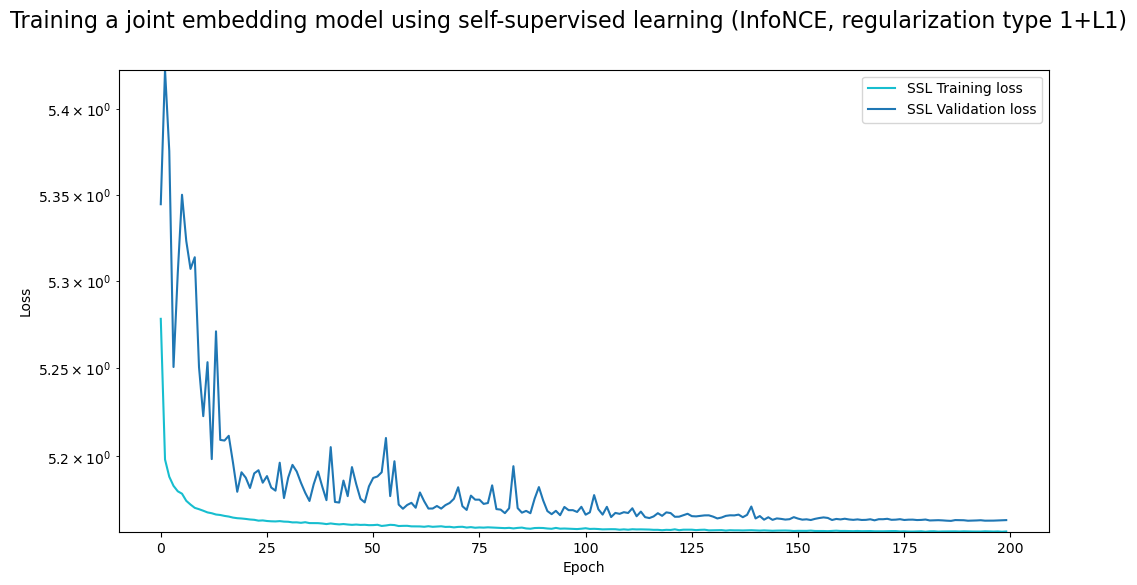

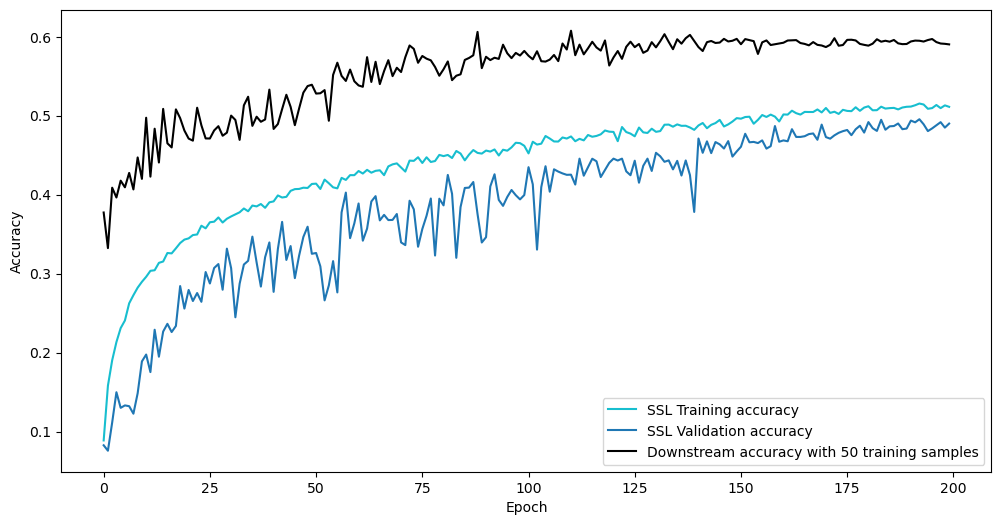

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.607600


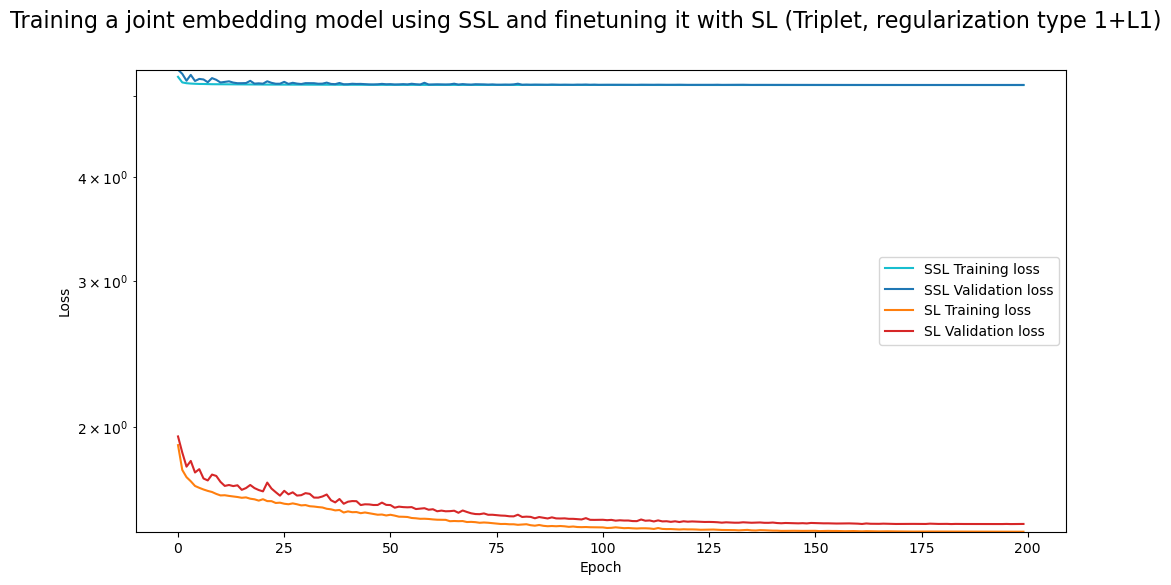

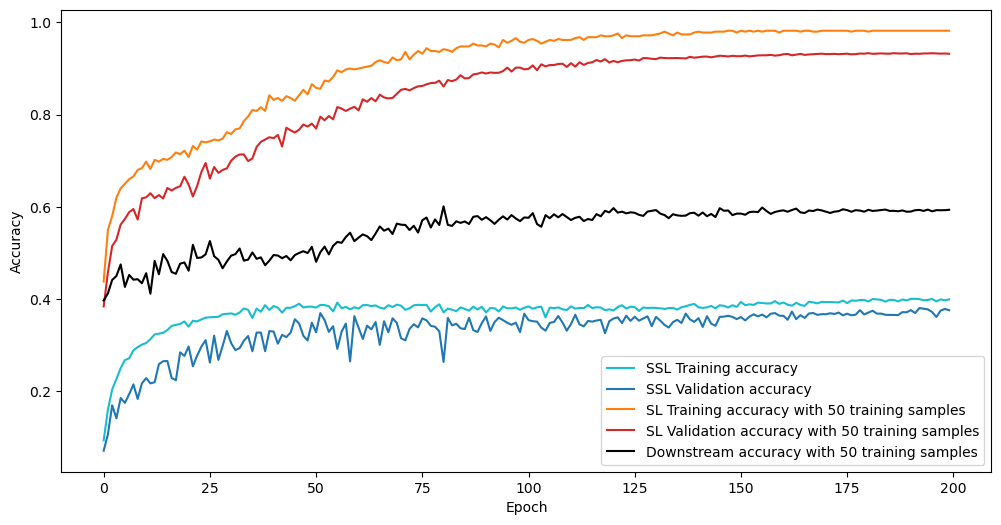

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.601100


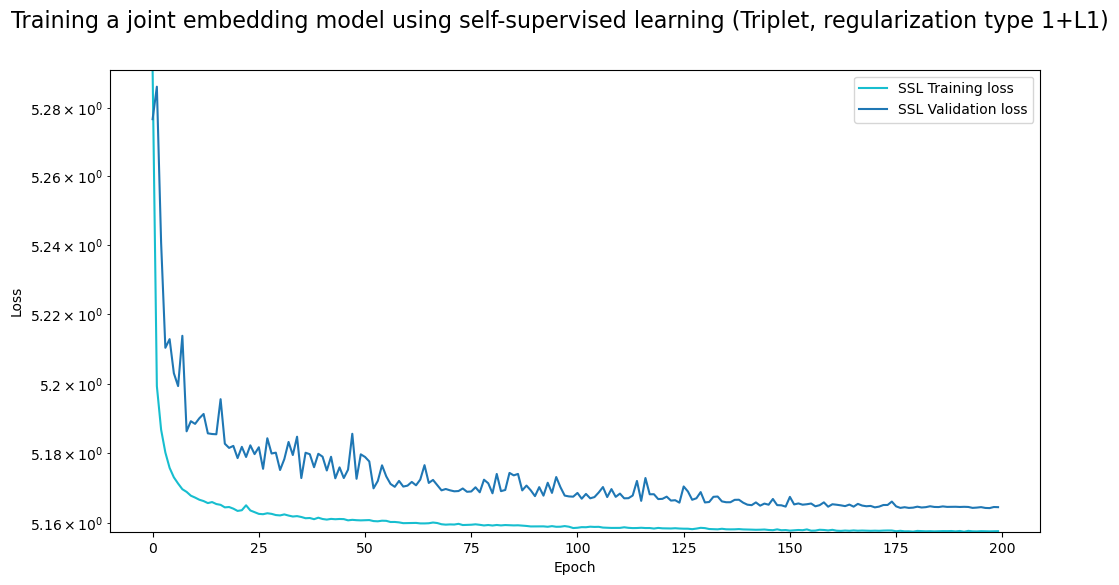

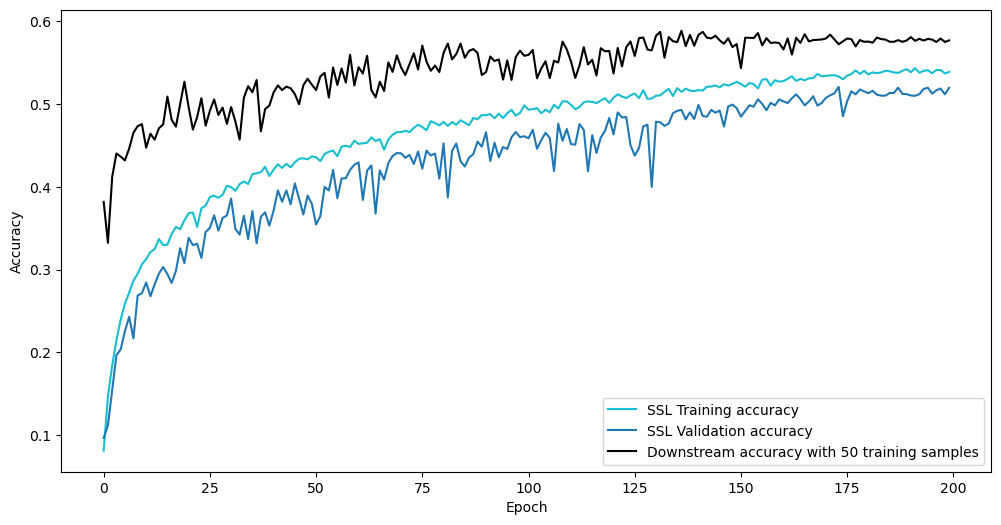

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.588800


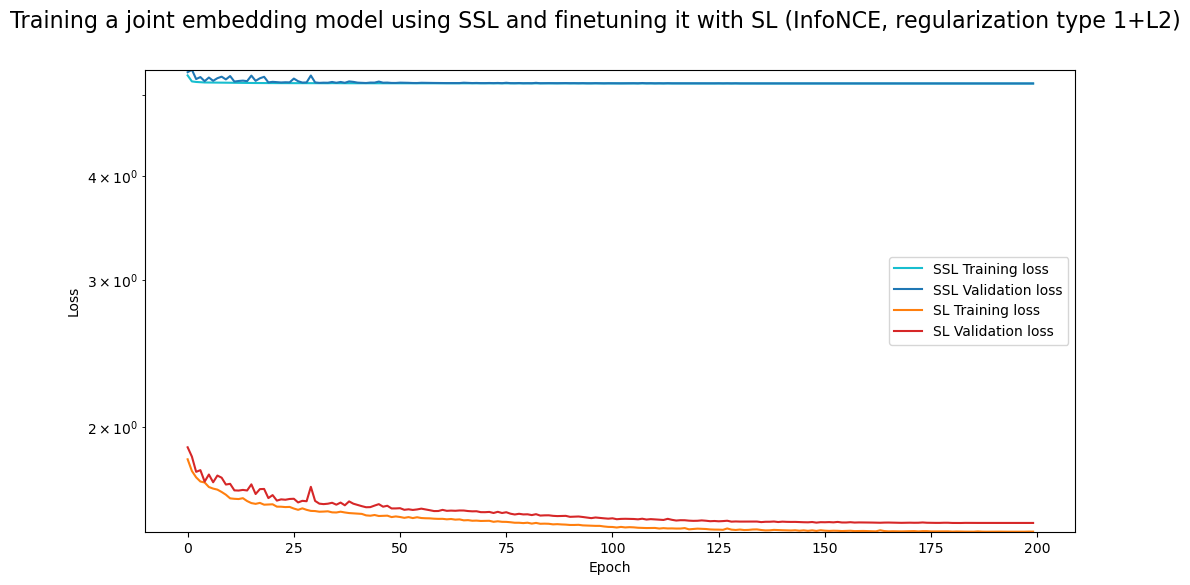

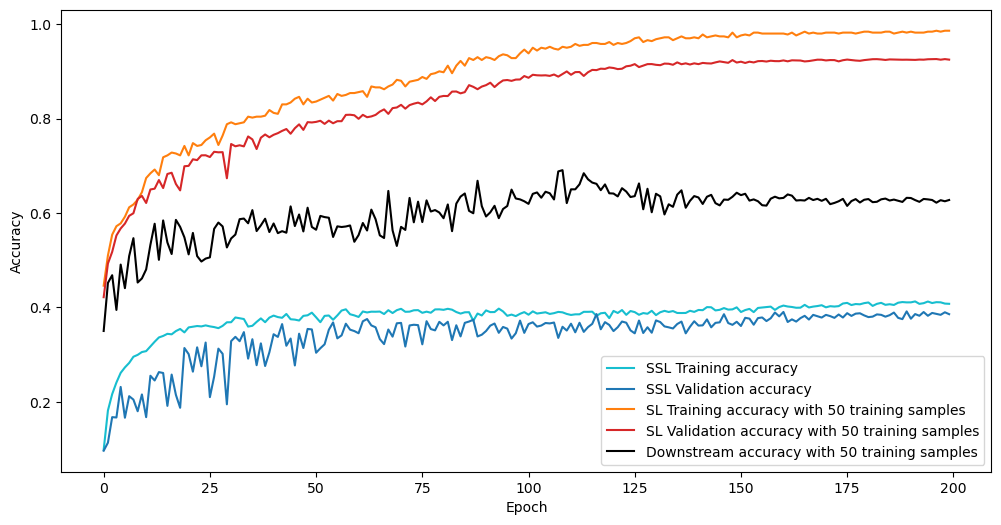

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.690700


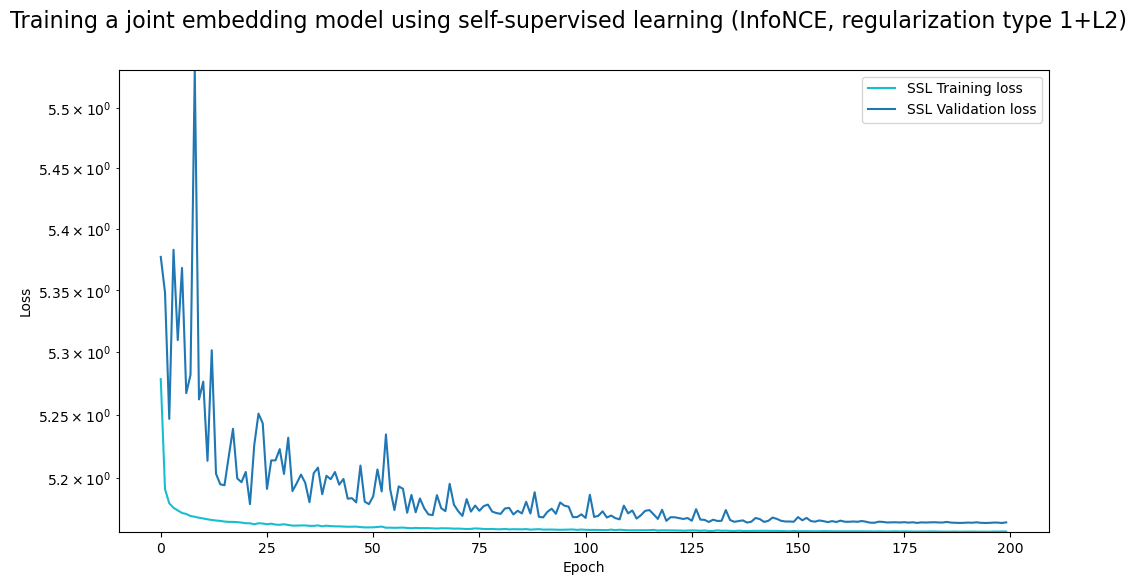

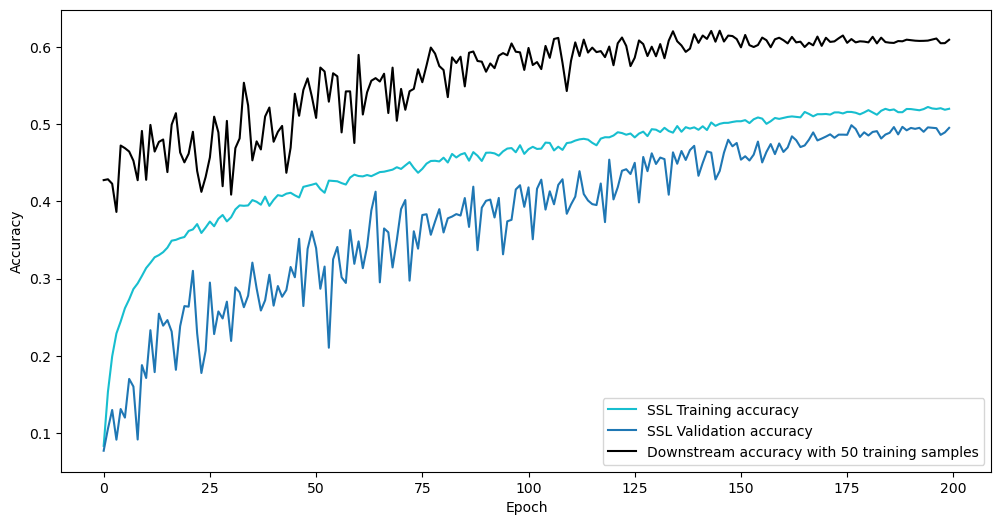

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.621000


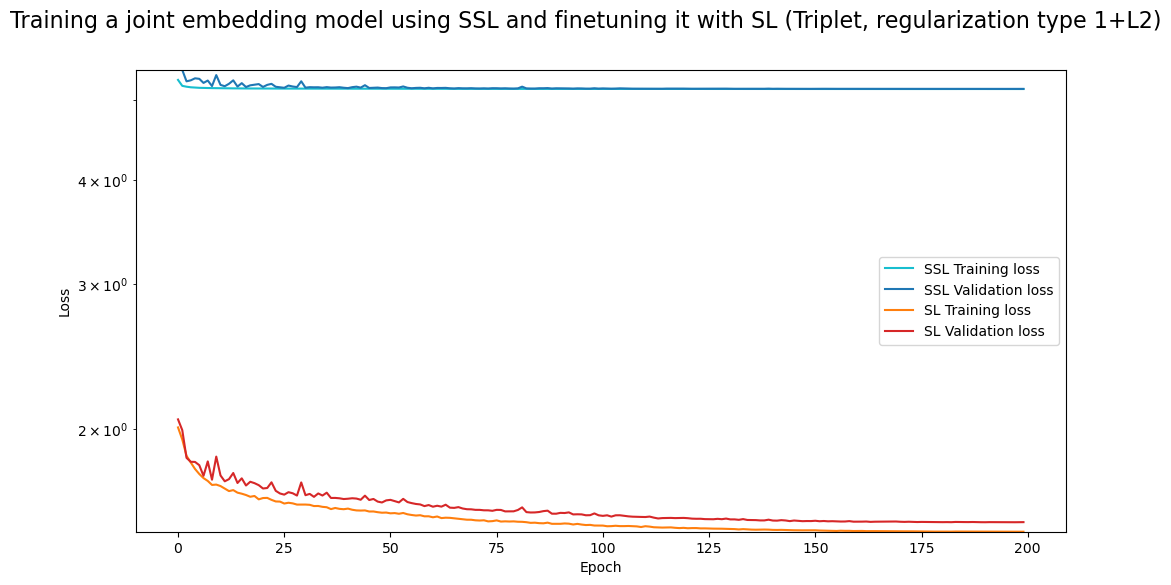

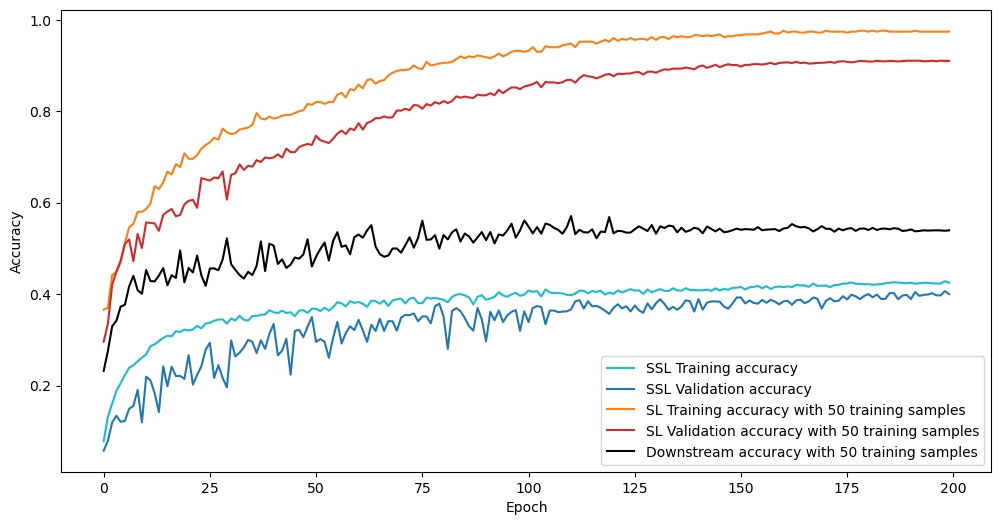

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.570700


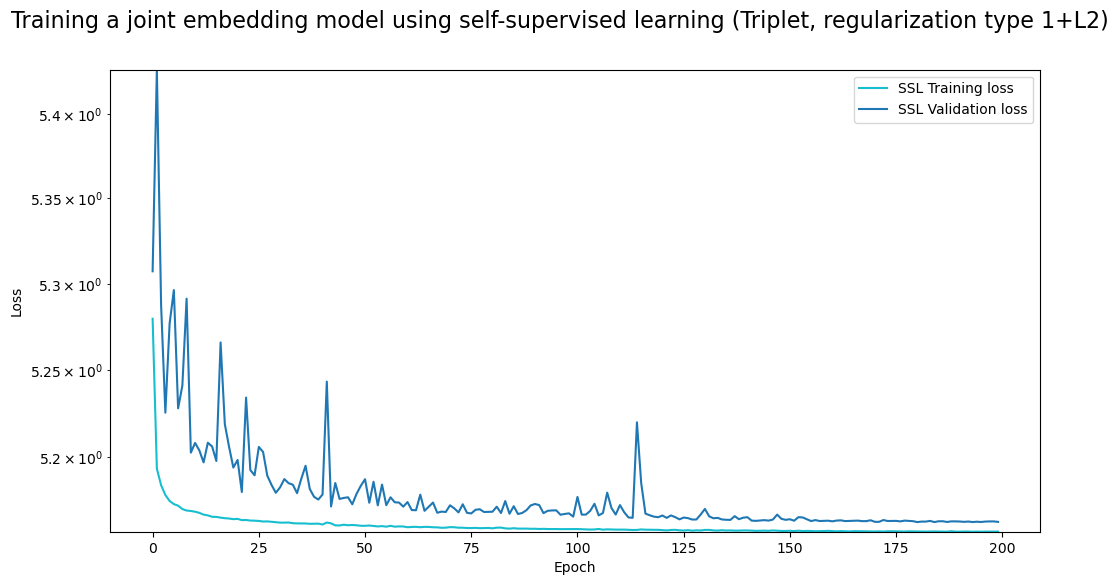

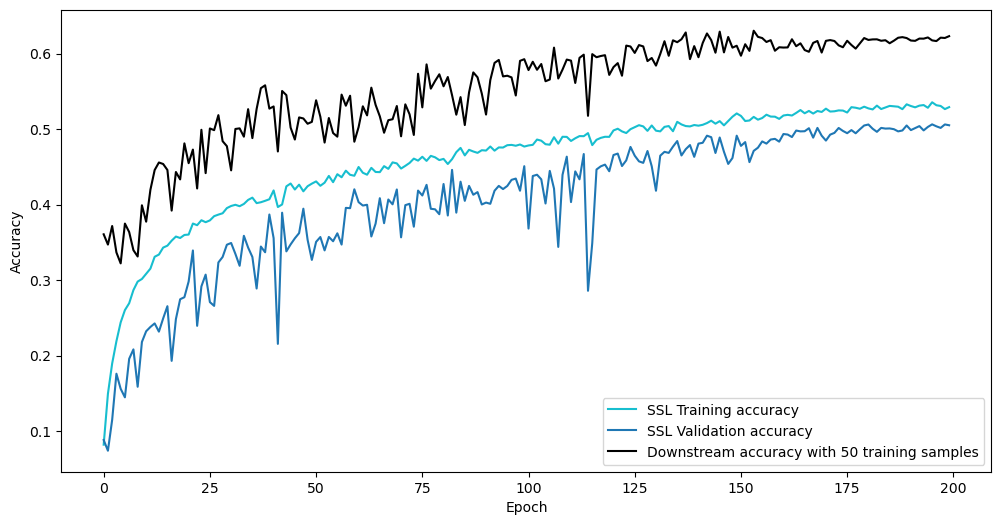

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.630300


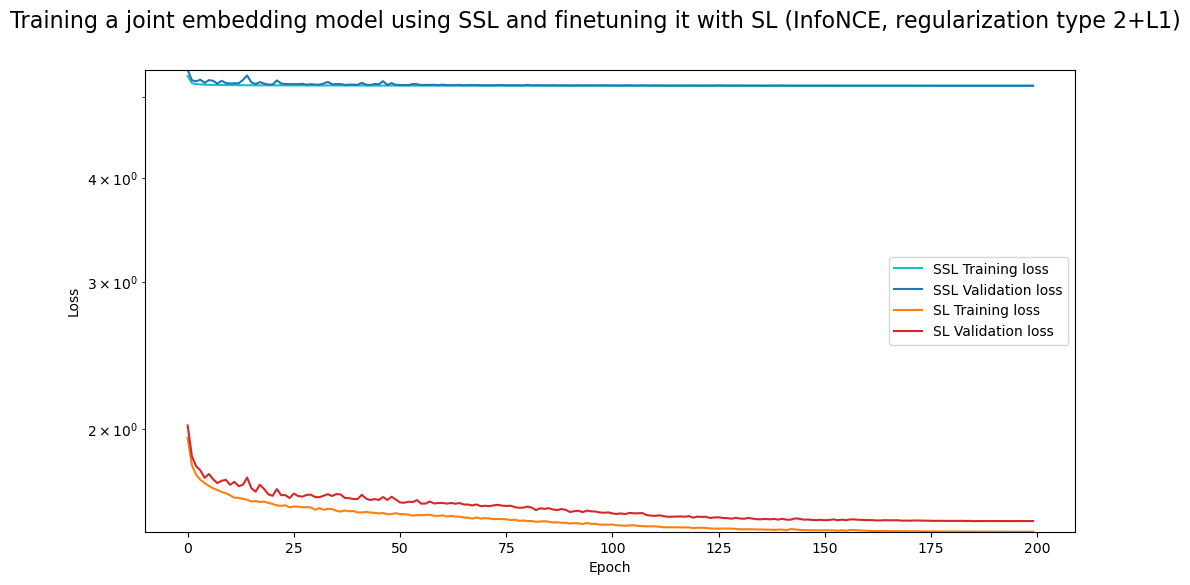

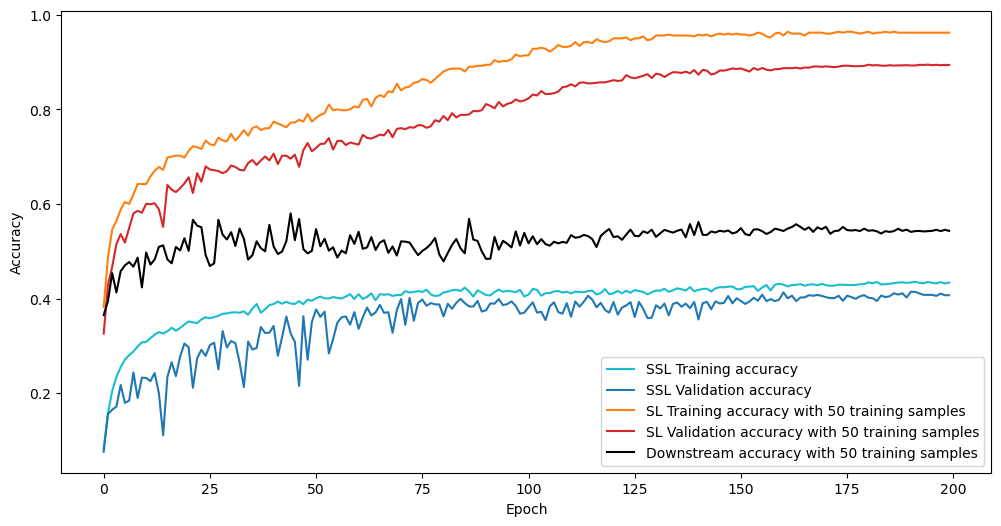

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.580000


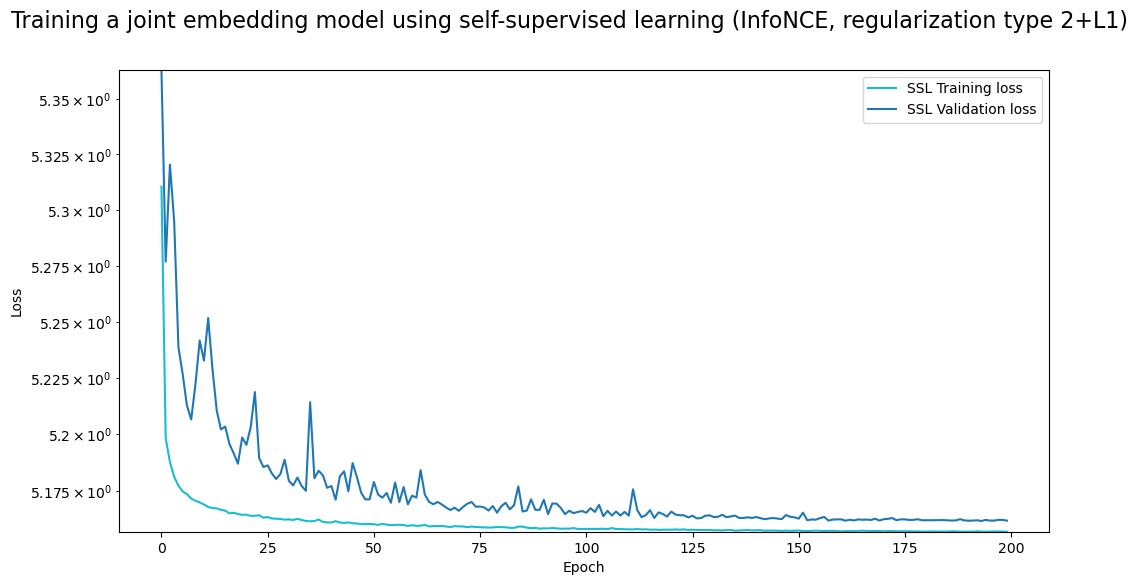

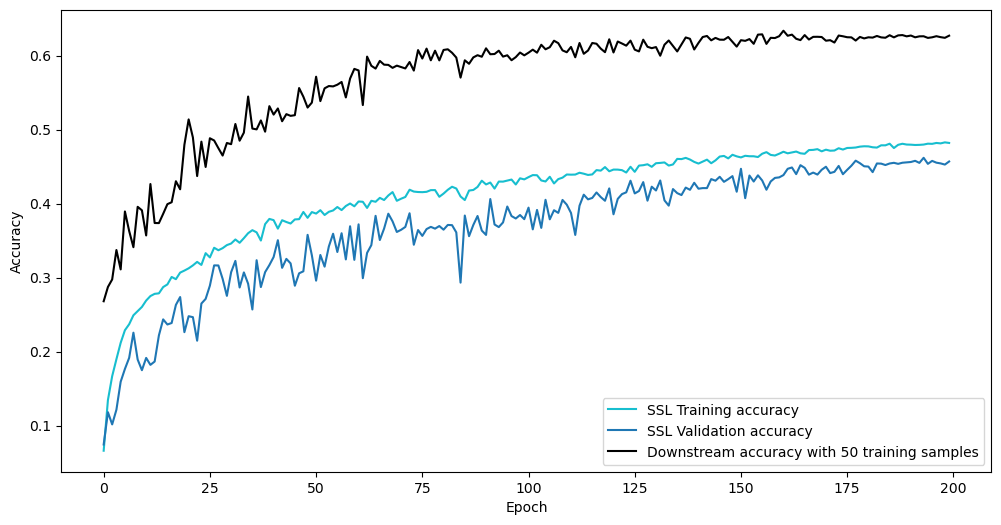

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.633800


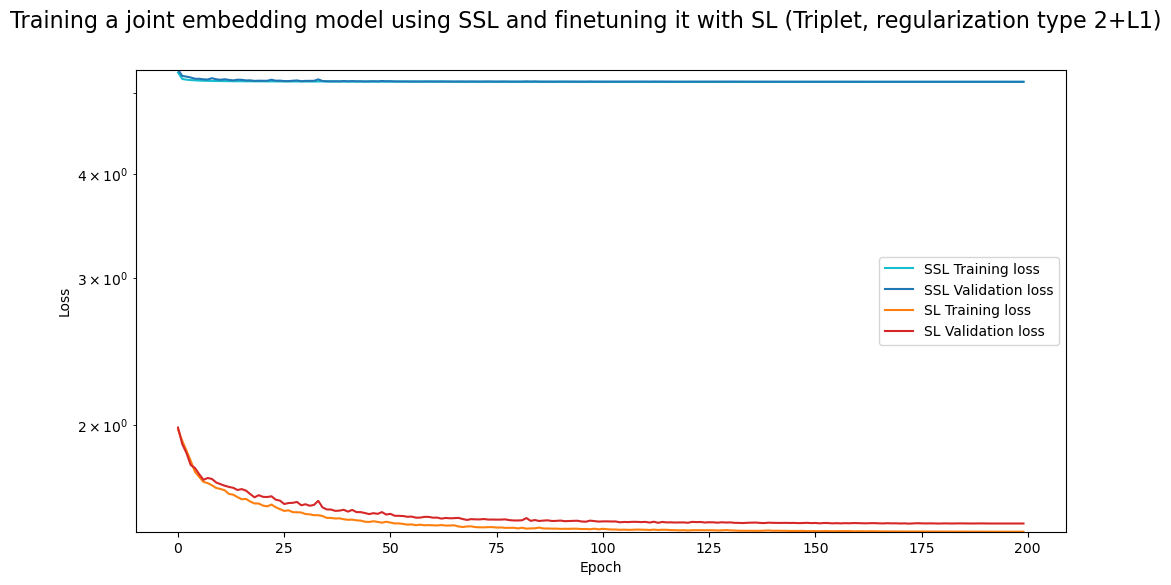

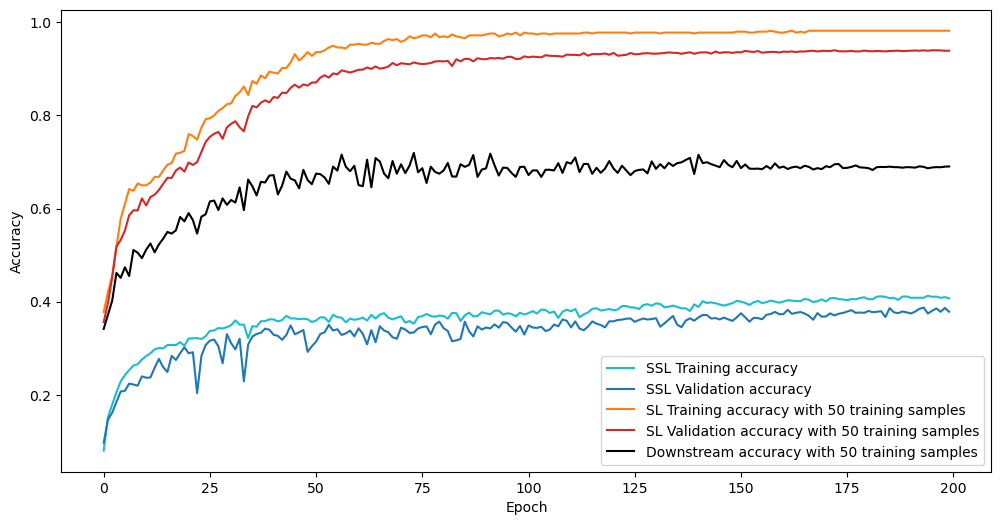

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.719500


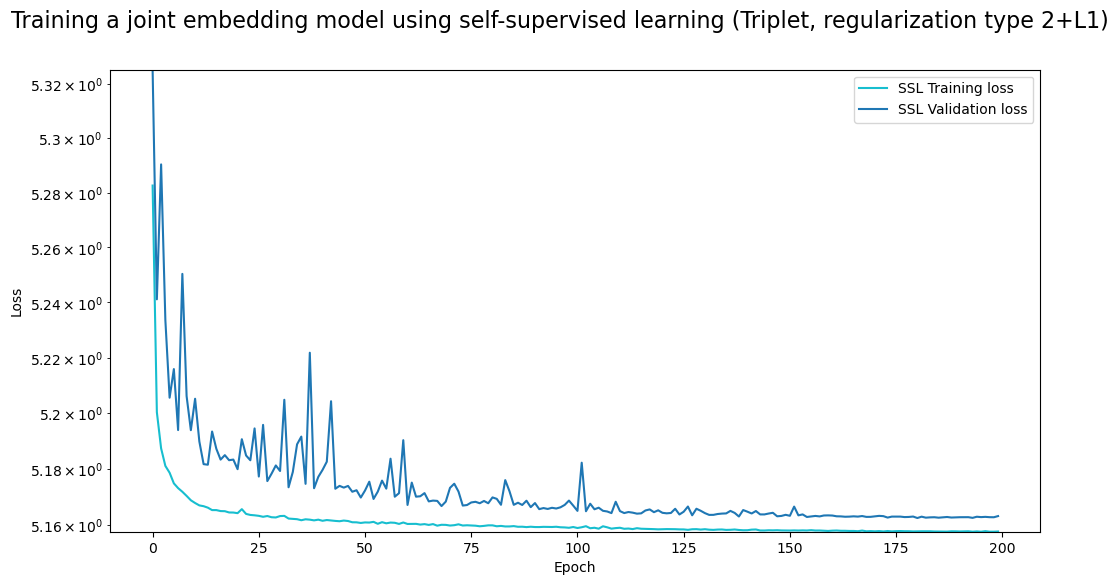

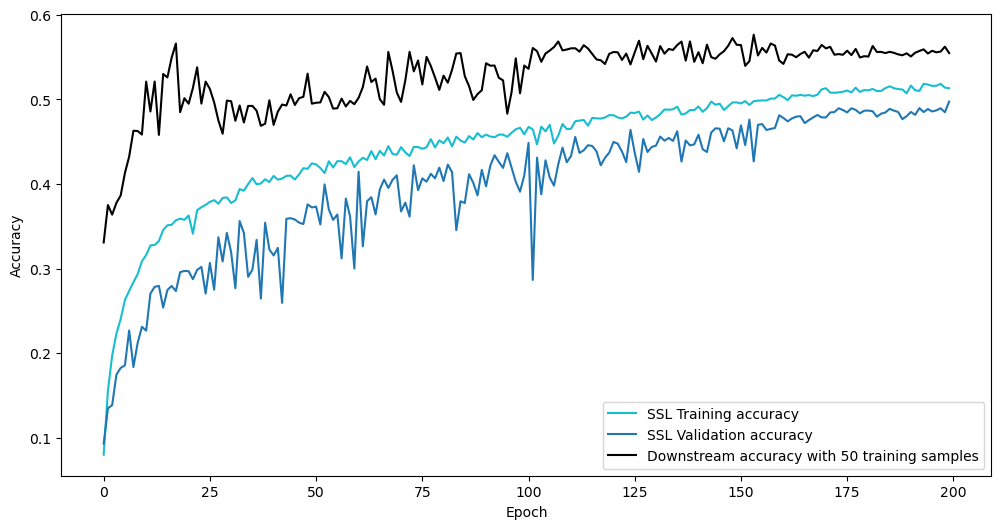

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.576300


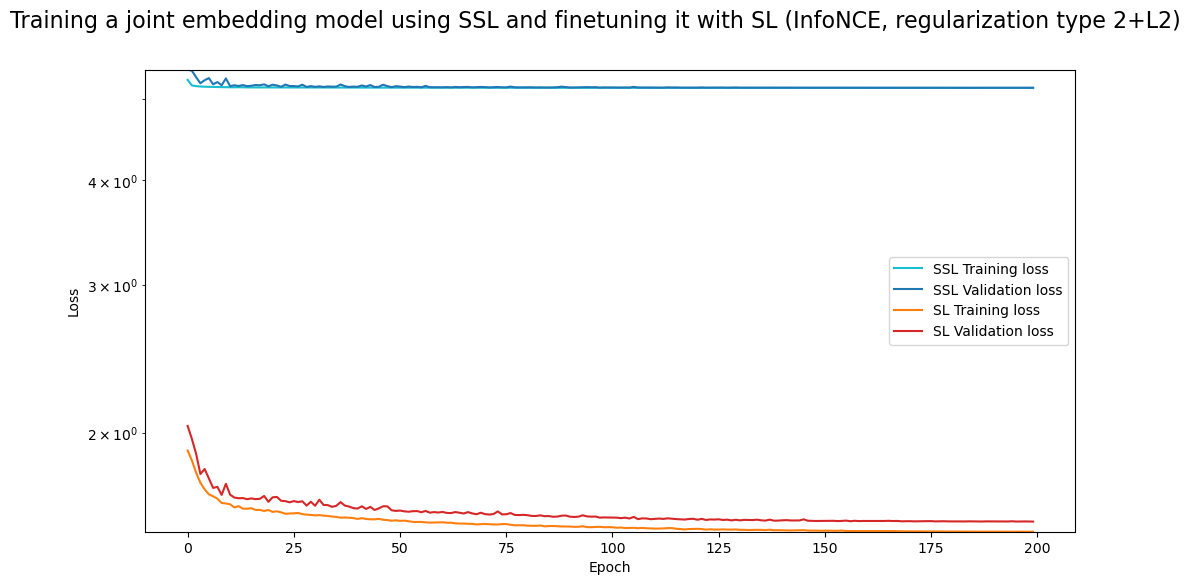

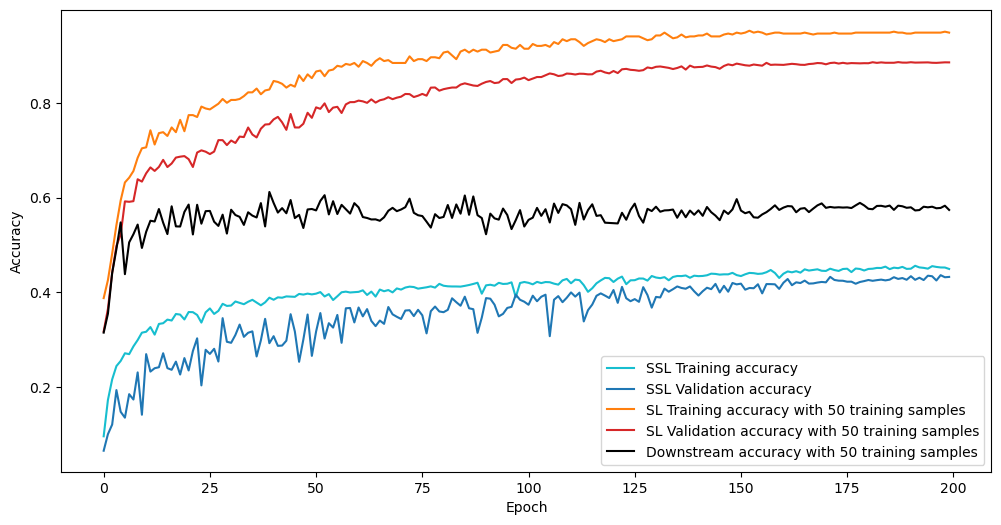

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.611900


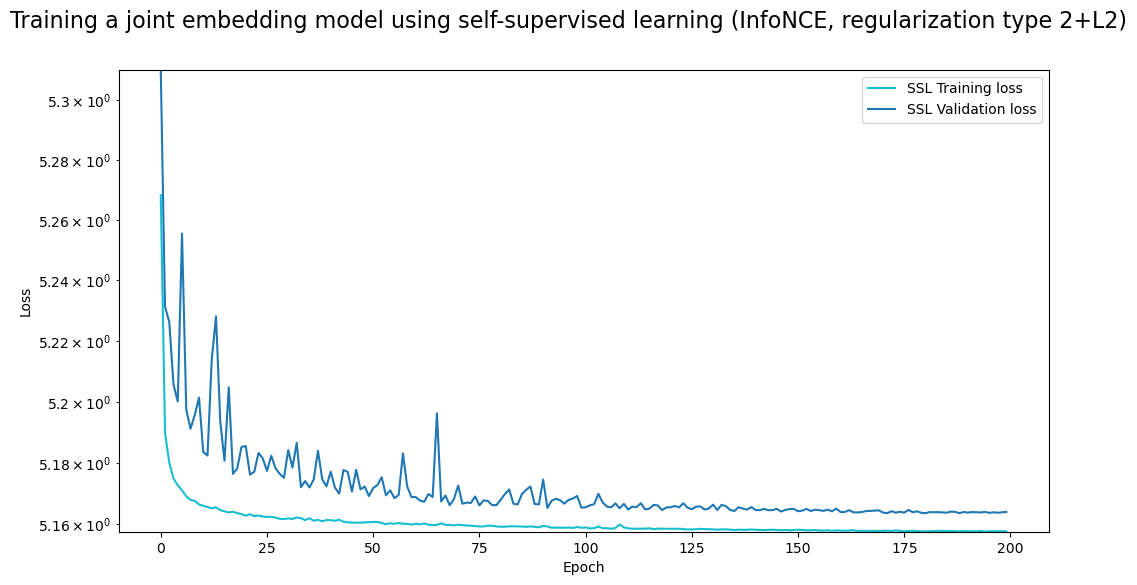

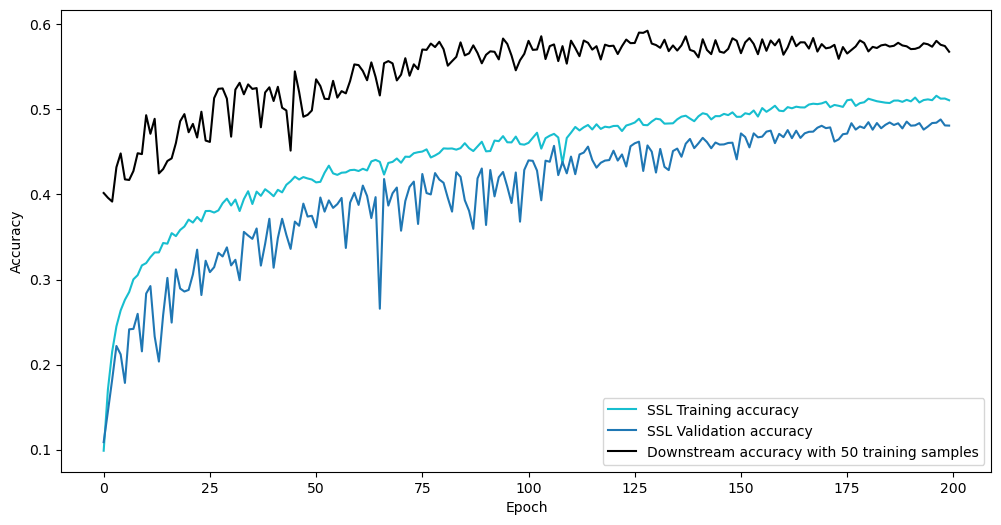

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.592400


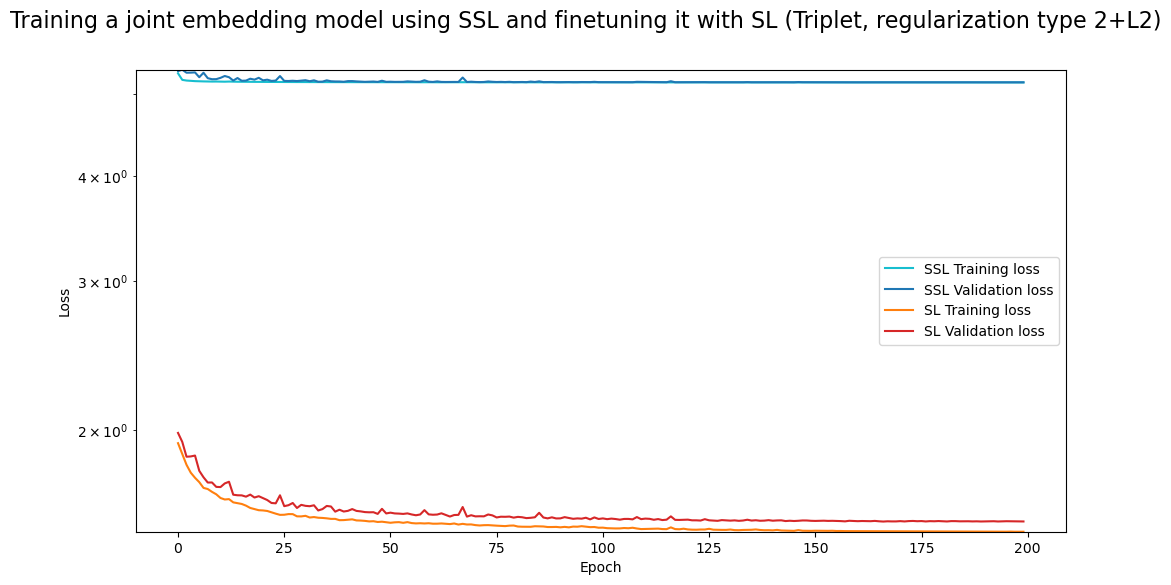

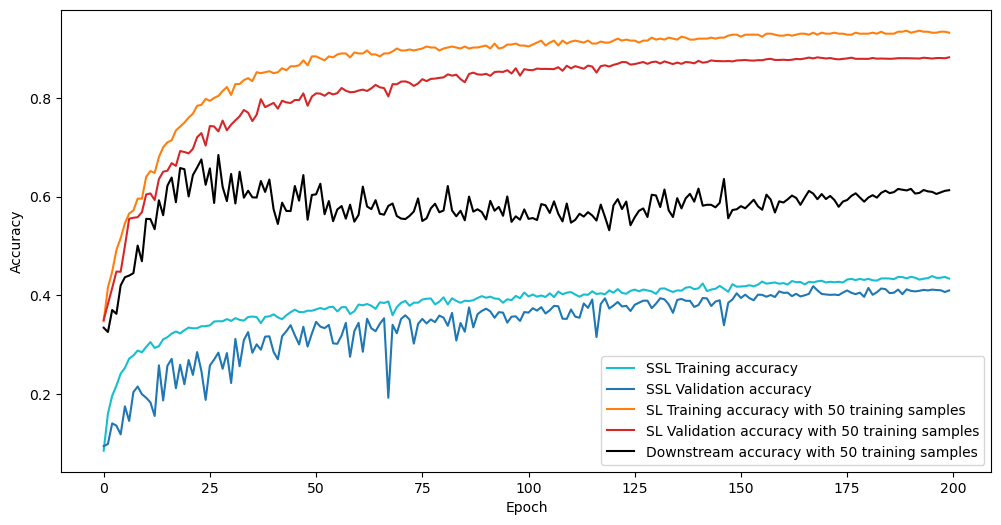

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.684400


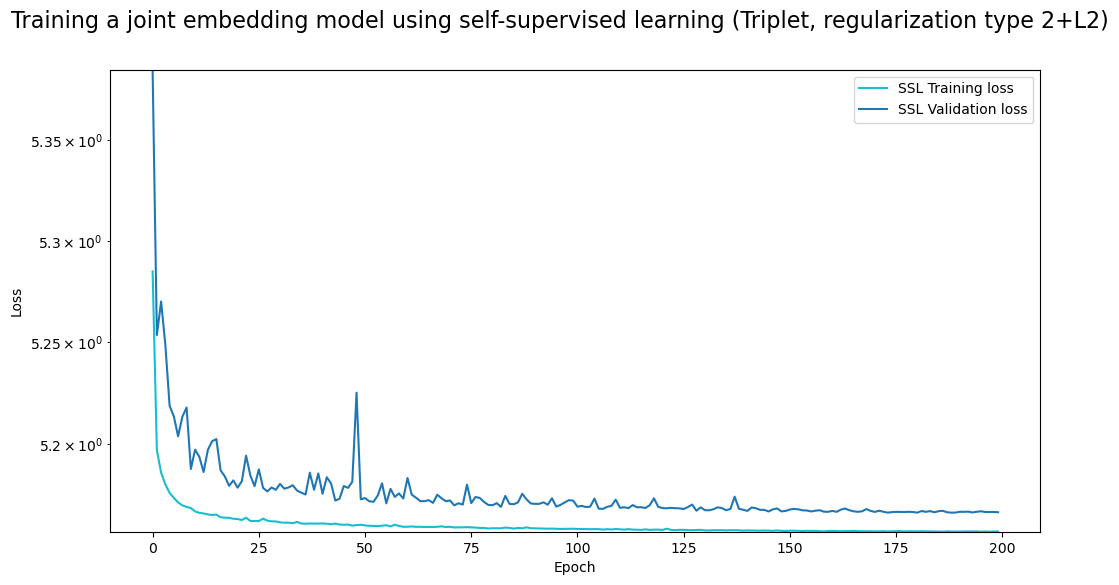

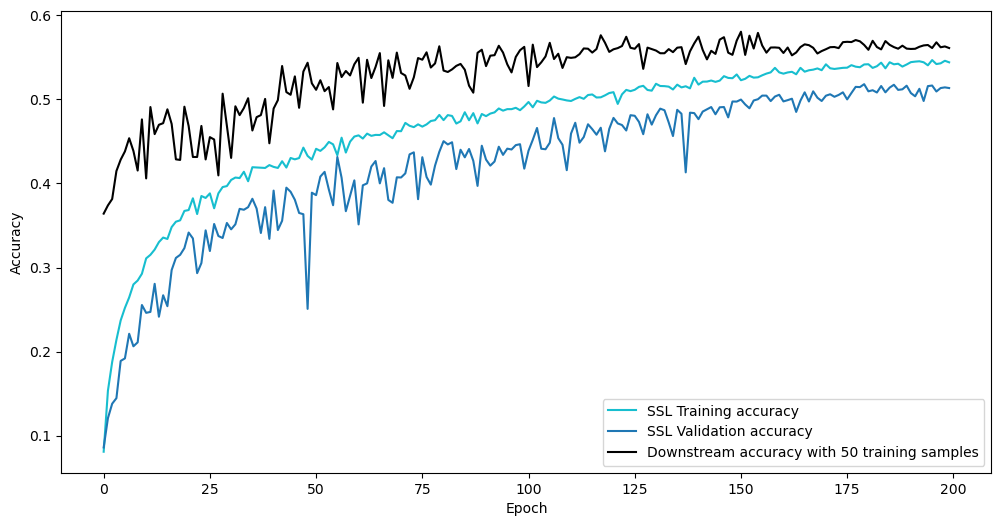

  0%|          | 0/200 [00:00<?, ?it/s]

Best downstream task accuracy: 0.580500
{True: {'acc': 0.7241, 'tower': MnistCnn(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=2048, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (fc): Linear(in_features=32, out_features=3, bias=True)
), 'config': {'regularization': 'no_regularization', 'loss_function': 'triplet_loss', 'finetune_with_sl': True}}, False: {'acc

In [21]:
folder_name = {
    False: "ssl_charts",
    True: "ssl_sl_charts",
}
filename_loss = {
    info_nce_loss: "infonce",
    triplet_loss: "triplet",
}
filename_reg = {
    no_regularization: "noreg",
    norm_regularization_1_l1: "reg1l1",
    norm_regularization_1_l2: "reg1l2",
    norm_regularization_2_l1: "reg2l1",
    norm_regularization_2_l2: "reg2l2",
}

plottitle_loss = {
    info_nce_loss: "InfoNCE",
    triplet_loss: "Triplet",
}

plottitle_reg = {
    no_regularization: "no regularization",
    norm_regularization_1_l1: "regularization type 1+L1",
    norm_regularization_1_l2: "regularization type 1+L2",
    norm_regularization_2_l1: "regularization type 2+L1",
    norm_regularization_2_l2: "regularization type 2+L2",
}

champion_ssl = {
    True: {
        "acc": 0,
        "tower": None,
        "config": None,
    },
    False: {
        "acc": 0,
        "tower": None,
        "config": None,
    },
}

regularizations = (no_regularization, norm_regularization_1_l1, norm_regularization_1_l2, norm_regularization_2_l1, norm_regularization_2_l2)
loss_functions = (info_nce_loss, triplet_loss)
finetune_with_sl_options = (True, False)

configs = list(itertools.product(regularizations, loss_functions, finetune_with_sl_options))

for (reg, loss_fn, finetune_with_sl) in tqdm_notebook(configs):
    if finetune_with_sl:
        plot_title = f"Training a joint embedding model using SSL and finetuning it with SL ({plottitle_loss[loss_fn]}, {plottitle_reg[reg]})"
        html_title = f"self-supervised joint embedding model trained with {plottitle_loss[loss_fn]} loss function, {plottitle_reg[reg]} and finetuned with supervised learning"
    else:
        plot_title = f"Training a joint embedding model using self-supervised learning ({plottitle_loss[loss_fn]}, {plottitle_reg[reg]})"
        html_title = f"self-supervised joint embedding model trained with {plottitle_loss[loss_fn]} loss function and {plottitle_reg[reg]}"
    
    model = MnistCnn(latent_size).to(device)
    best_tower, best_acc, plot_data = jem_ssl(model, info_nce_loss, no_regularization, finetune_with_sl=finetune_with_sl,
                                              plot_title=plot_title,
                                              epochs=200, silent=False, downstream_epochs=10, downstream_sample_count=50)
    export_plotly_html(plot_data, f"{folder_name[finetune_with_sl]}/{filename_loss[loss_fn]}_{filename_reg[reg]}.html", html_title)
    print(f"Best downstream task accuracy: {best_acc:3f}")
    if champion_ssl[finetune_with_sl]["acc"] < best_acc:
        champion_ssl[finetune_with_sl]["acc"] = best_acc
        champion_ssl[finetune_with_sl]["tower"] = best_tower
        champion_ssl[finetune_with_sl]["config"] = {
            "regularization": reg,
            "loss_function": loss_fn,
            "finetune_with_sl": finetune_with_sl,
        }

torch.save(champion_ssl[False]["tower"], "./champion_tower_ssl.pt")
torch.save(champion_ssl[True]["tower"], "./champion_tower_ssl_sl.pt")
print(champion_ssl)

  0%|          | 0/10 [00:00<?, ?it/s]

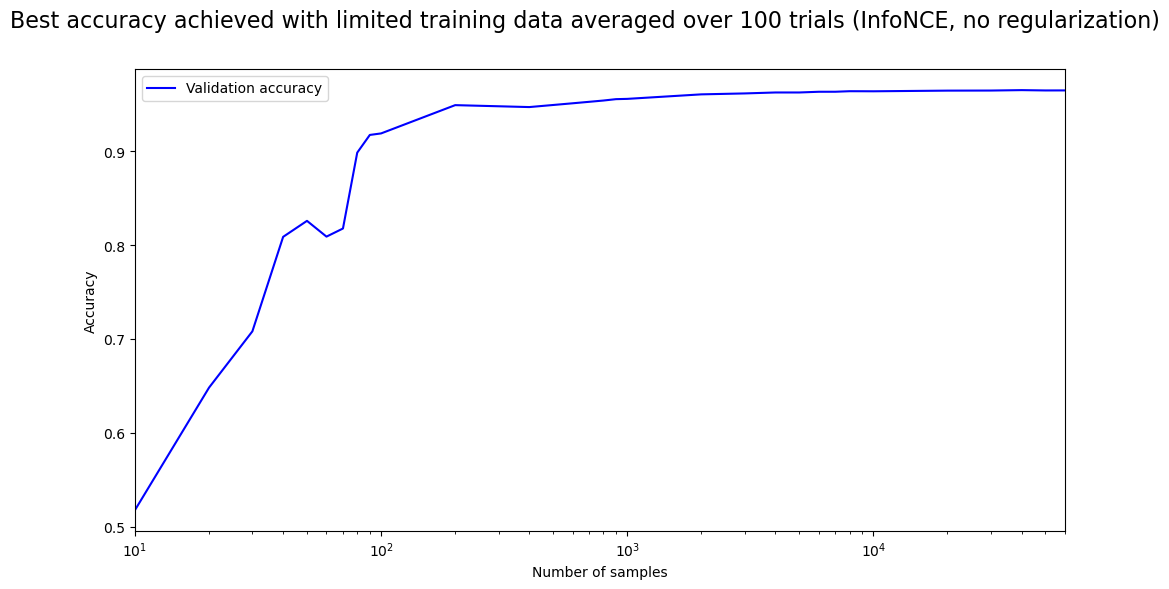

'<table>\n<tbody>\n<tr><td style="text-align: right;">10        </td><td style="text-align: right;">20        </td><td style="text-align: right;">30       </td><td style="text-align: right;">40        </td><td style="text-align: right;">50        </td><td style="text-align: right;">60        </td><td style="text-align: right;">70        </td><td style="text-align: right;">80        </td><td style="text-align: right;">90        </td><td style="text-align: right;">100        </td><td style="text-align: right;">200          </td><td style="text-align: right;">400         </td><td style="text-align: right;">600          </td><td style="text-align: right;">800          </td><td style="text-align: right;">900          </td><td style="text-align: right;">1000          </td><td style="text-align: right;">2000          </td><td style="text-align: right;">3000          </td><td style="text-align: right;">4000          </td><td style="text-align: right;">5000          </td><td style="text-align: right;">6000        </td><td style="text-align: right;">7000          </td><td style="text-align: right;">8000          </td><td style="text-align: right;">9000          </td><td style="text-align: right;">10000          </td><td style="text-align: right;">20000          </td><td style="text-align: right;">30000          </td><td style="text-align: right;">40000          </td><td style="text-align: right;">50000         </td><td style="text-align: right;">60000          </td></tr>\n<tr><td style="text-align: right;"> 0.51785  </td><td style="text-align: right;"> 0.64829  </td><td style="text-align: right;"> 0.70823 </td><td style="text-align: right;"> 0.80884  </td><td style="text-align: right;"> 0.82587  </td><td style="text-align: right;"> 0.80909  </td><td style="text-align: right;"> 0.81772  </td><td style="text-align: right;"> 0.89851  </td><td style="text-align: right;"> 0.91736  </td><td style="text-align: right;">  0.91898  </td><td style="text-align: right;">  0.94909    </td><td style="text-align: right;">  0.94703   </td><td style="text-align: right;">  0.95106    </td><td style="text-align: right;">  0.95399    </td><td style="text-align: right;">  0.95546    </td><td style="text-align: right;">   0.95576    </td><td style="text-align: right;">   0.96057    </td><td style="text-align: right;">   0.96156    </td><td style="text-align: right;">   0.96257    </td><td style="text-align: right;">   0.96257    </td><td style="text-align: right;">   0.96333  </td><td style="text-align: right;">   0.96335    </td><td style="text-align: right;">   0.96392    </td><td style="text-align: right;">   0.96389    </td><td style="text-align: right;">    0.96384    </td><td style="text-align: right;">    0.96454    </td><td style="text-align: right;">    0.96463    </td><td style="text-align: right;">    0.96508    </td><td style="text-align: right;">    0.96473   </td><td style="text-align: right;">    0.96477    </td></tr>\n<tr><td style="text-align: right;"> 0.0270784</td><td style="text-align: right;"> 0.0490034</td><td style="text-align: right;"> 0.042968</td><td style="text-align: right;"> 0.0301432</td><td style="text-align: right;"> 0.0297002</td><td style="text-align: right;"> 0.0427685</td><td style="text-align: right;"> 0.0296284</td><td style="text-align: right;"> 0.0189704</td><td style="text-align: right;"> 0.0175191</td><td style="text-align: right;">  0.0101648</td><td style="text-align: right;">  0.000445982</td><td style="text-align: right;">  0.00065582</td><td style="text-align: right;">  0.000776144</td><td style="text-align: right;">  0.000480521</td><td style="text-align: right;">  0.000688767</td><td style="text-align: right;">   0.000684398</td><td style="text-align: right;">   0.000268514</td><td style="text-align: right;">   0.000290517</td><td style="text-align: right;">   0.000340735</td><td style="text-align: right;">   0.000676831</td><td style="text-align: right;">   0.0005001</td><td style="text-align: right;">   0.000

In [44]:
data_point_x = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 400, 600, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 20000, 30000, 40000, 50000, 60000]
data_point_values = []
for i in tqdm_notebook(range(10)):
    data_points = []
    for c in data_point_x:
        best_acc = fine_tune_downstream_task(champion_ssl[True]["tower"], epochs=200, training_sample_count=c, DownstreamClass=ClusteredMnistCnnWithMlp)
        data_points.append(best_acc)
    data_point_values.append(data_points)
aggregated_values = [sum(values) / len(values) for values in zip(*data_point_values)]
plot_progress = Plots(charts={"Validation accuracy": "b"},
                      title=f"Best accuracy achieved with limited training data averaged over 100 trials (SSL, {plottitle_loss[champion_ssl[True]["config"]["loss_function"]]}, {plottitle_reg[champion_ssl[True]["config"]["regularization"]]})",
                      log_x=True, x_axis_title="Number of samples", y_axis_title="Accuracy")
for c, best_acc in zip(data_point_x, aggregated_values):
    plot_progress.add_point("Validation accuracy", c, best_acc)
    plot_progress.plot()
plot_progress.close()
aggregated_values_sq = [sum([v*v for v in values])/len(values) for values in zip(*data_point_values)]
aggregated_values_stdev = [math.sqrt(max(0, sq - avg*avg)) for sq, avg in zip(aggregated_values_sq, aggregated_values)]
tabulate.tabulate([data_point_x, aggregated_values, aggregated_values_stdev], tablefmt='html')